# Advanced NERTagger from GroningenMeaningBank

In [5]:
# Set information for the Model Training
import os
import nltk

LANGUAGE = 'english'
CORPUS_ROOT = "D:/AAA_ProgrammingFiles/AAA_Learning/AAA_Moocs/Coursera_NLP-Introduction/Processing Raw Text/models/gmb-2.2.0"

### Load the Corpus Data

In [6]:
import os
from nltk import conlltags2tree
 
def to_conll_iob(annotated_sentence):
    """
    `annotated_sentence` = list of triplets [(w1, t1, iob1), ...]
    Transform a pseudo-IOB notation: O, PERSON, PERSON, O, O, LOCATION, O
    to proper IOB notation: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    """
    proper_iob_tokens = []
    for idx, annotated_token in enumerate(annotated_sentence):
        tag, word, ner = annotated_token
 
        if ner != 'O':
            if idx == 0:
                ner = "B-" + ner
            elif annotated_sentence[idx - 1][2] == ner:
                ner = "I-" + ner
            else:
                ner = "B-" + ner
        proper_iob_tokens.append((tag, word, ner))
    return proper_iob_tokens
 
def read_gmb_ner(corpus_root):
    for root, dirs, files in os.walk(corpus_root):
        for filename in files:
            if filename.endswith(".tags"):
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    file_content = file_handle.read().decode('utf-8').strip()
                    annotated_sentences = file_content.split('\n\n')
                    for annotated_sentence in annotated_sentences:
                        annotated_tokens = [seq for seq in annotated_sentence.split('\n') if seq]
 
                        standard_form_tokens = []
 
                        for idx, annotated_token in enumerate(annotated_tokens):
                            annotations = annotated_token.split('\t')
                            word, tag, ner = annotations[0], annotations[1], annotations[3]
 
                            if ner != 'O':
                                ner = ner.split('-')[0]
 
                            standard_form_tokens.append((word, tag, ner))
 
                        conll_tokens = to_conll_iob(standard_form_tokens)
                        yield conlltags2tree(conll_tokens)

#### Test the Corpus reader

In [18]:
corpus = read_gmb_ner()

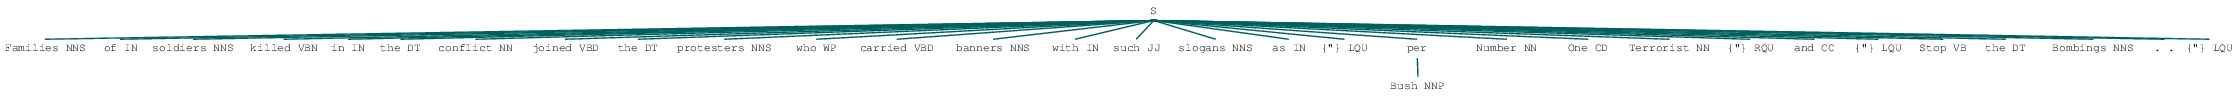

In [20]:
corpus.__next__()

### Create Word Features

First the type of word itself is important

In [7]:
import re
 
def shape(word):
    word_shape = 'other'
    if re.match('[0-9]+(\.[0-9]*)?|[0-9]*\.[0-9]+$', word):
        word_shape = 'number'
    elif re.match('\W+$', word):
        word_shape = 'punct'
    elif re.match('[A-Z][a-z]+$', word):
        word_shape = 'capitalized'
    elif re.match('[A-Z]+$', word):
        word_shape = 'uppercase'
    elif re.match('[a-z]+$', word):
        word_shape = 'lowercase'
    elif re.match('[A-Z][a-z]+[A-Z][a-z]+[A-Za-z]*$', word):
        word_shape = 'camelcase'
    elif re.match('[A-Za-z]+$', word):
        word_shape = 'mixedcase'
    elif re.match('__.+__$', word):
        word_shape = 'wildcard'
    elif re.match('[A-Za-z0-9]+\.$', word):
        word_shape = 'ending-dot'
    elif re.match('[A-Za-z0-9]+\.[A-Za-z0-9\.]+\.$', word):
        word_shape = 'abbreviation'
    elif re.match('[A-Za-z0-9]+\-[A-Za-z0-9\-]+.*$', word):
        word_shape = 'contains-hyphen'
 
    return word_shape

In [89]:
print(shape('0.24325234aasdf5'))
print(shape('lakdjsf'))
print(shape('Llkjlkj'))
print(shape('LASJDKFSD'))

number
lowercase
capitalized
uppercase


In [8]:
from nltk.stem.snowball import SnowballStemmer
 
stemmer = SnowballStemmer('english')
 
def ner_features(tokens, index, history):
    """
    `tokens`  = a POS-tagged sentence [(w1, t1), ...]
    `index`   = the index of the token we want to extract features for
    `history` = the previous predicted IOB tags
    """
 
    # Pad the sequence with placeholders
    tokens = [('__START2__', '__START2__'), ('__START1__', '__START1__')] + list(tokens) + [('__END1__', '__END1__'), ('__END2__', '__END2__')]
    history = ['__START2__', '__START1__'] + list(history)
 
    # shift the index with 2, to accommodate the padding
    index += 2
 
    word, pos = tokens[index]
    prevword, prevpos = tokens[index - 1]
    prevprevword, prevprevpos = tokens[index - 2]
    nextword, nextpos = tokens[index + 1]
    nextnextword, nextnextpos = tokens[index + 2]
    previob = history[index -1]
    prevpreviob = history[index -2]
 
    feat_dict = {
        'word': word,
        'lemma': stemmer.stem(word),
        'pos': pos,
        'shape': shape(word),
 
        'next-word': nextword,
        'next-pos': nextpos,
        'next-lemma': stemmer.stem(nextword),
        'next-shape': shape(nextword),
 
        'next-next-word': nextnextword,
        'next-next-pos': nextnextpos,
        'next-next-lemma': stemmer.stem(nextnextword),
        'next-next-shape': shape(nextnextword),
 
        'prev-word': prevword,
        'prev-pos': prevpos,
        'prev-lemma': stemmer.stem(prevword),
        'prev-iob': previob,
        'prev-shape': shape(prevword),
 
        'prev-prev-word': prevprevword,
        'prev-prev-pos': prevprevpos,
        'prev-prev-lemma': stemmer.stem(prevprevword),
        'prev-prev-iob': prevpreviob,
        'prev-prev-shape': shape(prevprevword),
    }
 
    return feat_dict

### Enabling to learn the Data in Batches (Out of Core)

In [9]:
import itertools
 
from nltk import tree2conlltags
from nltk.chunk import ChunkParserI
from sklearn.linear_model import Perceptron
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
 
class ScikitLearnChunker(ChunkParserI):
 
    @classmethod
    def to_dataset(cls, parsed_sentences, feature_detector):
        """
        Transform a list of tagged sentences into a scikit-learn compatible POS dataset
        :param parsed_sentences:
        :param feature_detector:
        :return:
        """
        X, y = [], []
        for parsed in parsed_sentences:
            iob_tagged = tree2conlltags(parsed)
            words, tags, iob_tags = zip(*iob_tagged)
 
            tagged = list(zip(words, tags))
 
            for index in range(len(iob_tagged)):
                X.append(feature_detector(tagged, index, history=iob_tags[:index]))
                y.append(iob_tags[index])
 
        return X, y
 
    @classmethod
    def get_minibatch(cls, parsed_sentences, feature_detector, batch_size=500):
        batch = list(itertools.islice(parsed_sentences, batch_size))
        X, y = cls.to_dataset(batch, feature_detector)
        return X, y
 
    @classmethod
    def train(cls, parsed_sentences, feature_detector, all_classes, **kwargs):
        X, y = cls.get_minibatch(parsed_sentences, feature_detector, kwargs.get('batch_size', 1500))
        vectorizer = DictVectorizer(sparse=False)
        vectorizer.fit(X)
 
        clf = Perceptron(verbose=10, n_jobs=-1, n_iter=kwargs.get('n_iter', 5))
 
        while len(X):
            X = vectorizer.transform(X)
            clf.partial_fit(X, y, all_classes)
            X, y = cls.get_minibatch(parsed_sentences, feature_detector, kwargs.get('batch_size', 1500))
 
        clf = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
 
        return cls(clf, feature_detector)
 
    def __init__(self, classifier, feature_detector):
        self._classifier = classifier
        self._feature_detector = feature_detector
 
    def parse(self, tokens):
        """
        Chunk a tagged sentence
        :param tokens: List of words [(w1, t1), (w2, t2), ...]
        :return: chunked sentence: nltk.Tree
        """
        history = []
        iob_tagged_tokens = []
        for index, (word, tag) in enumerate(tokens):
            iob_tag = self._classifier.predict([self._feature_detector(tokens, index, history)])[0]
            history.append(iob_tag)
            iob_tagged_tokens.append((word, tag, iob_tag))
 
        return conlltags2tree(iob_tagged_tokens)
 
    def score(self, parsed_sentences):
        """
        Compute the accuracy of the tagger for a list of test sentences
        :param parsed_sentences: List of parsed sentences: nltk.Tree
        :return: float 0.0 - 1.0
        """
        X_test, y_test = self.__class__.to_dataset(parsed_sentences, self._feature_detector)
        return self._classifier.score(X_test, y_test)

In [129]:
def train_perceptron():
    reader = read_gmb_ner(CORPUS_ROOT)
    
    all_classes = ['O', 'B-per', 'I-per', 'B-gpe', 'I-gpe', 
                   'B-geo', 'I-geo', 'B-org', 'I-org', 'B-tim', 'I-tim',
                   'B-art', 'I-art', 'B-eve', 'I-eve', 'B-nat', 'I-nat']
    
    chunker = ScikitLearnChunker.train(itertools.islice(reader, 50000), feature_detector=ner_features,
                                     all_classes=all_classes, batch_size=500, n_iter=5)
    return chunker

In [131]:
chunker = train_perceptron()

-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 51.01, NNZs: 1372, Bias: -8.000000, T: 10976, Avg. loss: 0.117438
Total training time: 0.83 seconds.
Norm: 56.66, NNZs: 1506, Bias: 3.000000, T: 10976, Avg. loss: 0.101676
Total training time: 0.81 seconds.
Norm: 24.33, NNZs: 382, Bias: -5.000000, T: 10976, Avg. loss: 0.010660
Total training time: 0.89 seconds.
Norm: 26.08, NNZs: 390, Bias: -6.000000, T: 10976, Avg. loss: 0.015579
Total training time: 0.95 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    1.9s


Norm: 26.68, NNZs: 509, Bias: -4.000000, T: 10976, Avg. loss: 0.025510
Norm: 60.38, NNZs: 1753, Bias: -8.000000, T: 10976, Avg. loss: 0.157890Total training time: 1.05 seconds.

Total training time: 1.02 seconds.
Norm: 49.54, NNZs: 1057, Bias: -7.000000, T: 10976, Avg. loss: 0.069333
Total training time: 1.01 seconds.
Norm: 17.78, NNZs: 217, Bias: -4.000000, T: 10976, Avg. loss: 0.003735
Total training time: 0.96 seconds.
Norm: 10.86, NNZs: 97, Bias: -3.000000, T: 10976, Avg. loss: 0.001549
Total training time: 1.03 seconds.
Norm: 14.70, NNZs: 150, Bias: -3.000000, T: 10976, Avg. loss: 0.003371Norm: 40.22, NNZs: 833, Bias: -8.000000, T: 10976, Avg. loss: 0.028152

Total training time: 1.04 seconds.Total training time: 1.14 seconds.

Norm: 17.15, NNZs: 226, Bias: -4.000000, T: 10976, Avg. loss: 0.008929
Total training time: 1.06 seconds.
Norm: 18.17, NNZs: 234, Bias: -5.000000, T: 10976, Avg. loss: 0.005831
Total training time: 1.09 seconds.
Norm: 45.54, NNZs: 1101, Bias: -7.000000, T: 

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 13.56, NNZs: 148, Bias: -4.000000, T: 11101, Avg. loss: 0.002793
Total training time: 1.64 seconds.
Norm: 64.77, NNZs: 1621, Bias: -8.000000, T: 11101, Avg. loss: 0.100171
Total training time: 1.56 seconds.
Norm: 29.15, NNZs: 619, Bias: -5.000000, T: 11101, Avg. loss: 0.014053
Total training time: 1.70 seconds.
Norm: 68.01, NNZs: 2089, Bias: -11.000000, T: 11101, Avg. loss: 0.110441
Total training time: 1.75 seconds.
Norm: 54.93, NNZs: 1450, Bias: -9.000000, T: 11101, Avg. loss: 0.075399
Total training time: 1.79 seconds.
Norm: 26.72, NNZs: 417, Bias: -4.000000, T: 11101, Avg. loss: 0.000000
Total training time: 1.74 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.6s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.7s remaining:    3.3s


Norm: 25.77, NNZs: 400, Bias: -6.000000, T: 11101, Avg. loss: 0.001261
Total training time: 1.83 seconds.
Norm: 33.67, NNZs: 578, Bias: -5.000000, T: 11101, Avg. loss: 0.023511Norm: 18.06, NNZs: 209, Bias: -4.000000, T: 11101, Avg. loss: 0.002612

Total training time: 1.79 seconds.Total training time: 1.81 seconds.

Norm: 64.09, NNZs: 2000, Bias: -10.000000, T: 11101, Avg. loss: 0.163319
Total training time: 1.78 seconds.
Norm: 36.33, NNZs: 625, Bias: -6.000000, T: 11101, Avg. loss: 0.012161
Total training time: 1.80 seconds.
Norm: 20.62, NNZs: 309, Bias: -5.000000, T: 11101, Avg. loss: 0.011891
Total training time: 1.93 seconds.
Norm: 34.84, NNZs: 536, Bias: -6.000000, T: 11101, Avg. loss: 0.013152
Total training time: 1.94 seconds.
Norm: 65.75, NNZs: 1919, Bias: -12.000000, T: 11101, Avg. loss: 0.163319Norm: 74.22, NNZs: 2365, Bias: 0.000000, T: 11101, Avg. loss: 0.218809

Total training time: 2.02 seconds.Total training time: 1.93 seconds.

Norm: 21.40, NNZs: 271, Bias: -4.000000, T

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    2.0s finished



Total training time: 2.02 seconds.
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 75.16, NNZs: 1988, Bias: -10.000000, T: 11360, Avg. loss: 0.078697Norm: 20.35, NNZs: 309, Bias: -4.000000, T: 11360, Avg. loss: 0.001673Norm: 49.76, NNZs: 1131, Bias: -10.000000, T: 11360, Avg. loss: 0.016373Norm: 22.32, NNZs: 275, Bias: -5.000000, T: 11360, Avg. loss: 0.000264Norm: 72.64, NNZs: 2251, Bias: -12.000000, T: 11360, Avg. loss: 0.054049



Total training time: 1.07 seconds.
Total training time: 1.08 seconds.Total training time: 1.06 seconds.Total training time: 1.03 seconds.
Total training time: 1.00 seconds.



Norm: 15.87, NNZs: 179, Bias: -4.000000, T: 11360, Avg. loss: 0.002289Norm: 78.45, NNZs: 2380, Bias: -14.000000, T: 11360, Avg. loss: 0.164965Norm: 27.09, NNZs: 409, Bias: -7.000000, T: 11360, Avg. loss: 0.001056


Total training time: 1.14 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 82.02, NNZs: 2232, Bias: -9.000000, T: 10959, Avg. loss: 0.076923Norm: 29.60, NNZs: 665, Bias: -5.000000, T: 10959, Avg. loss: 0.000182Norm: 15.87, NNZs: 179, Bias: -4.000000, T: 10959, Avg. loss: 0.000000

Total training time: 0.72 seconds.
Total training time: 0.74 seconds.
Total training time: 0.76 seconds.

Norm: 42.19, NNZs: 739, Bias: -8.000000, T: 10959, Avg. loss: 0.005110Norm: 99.10, NNZs: 3517, Bias: 3.000000, T: 10959, Avg. loss: 0.202573Norm: 24.06, NNZs: 276, Bias: -6.000000, T: 10959, Avg. loss: 0.000547Norm: 81.88, NNZs: 2756, Bias: -11.000000, T: 10959, Avg. loss: 0.154029Norm: 25.46, NNZs: 393, Bias: -4.000000, T: 10959, Avg. loss: 0.008577




Total training time: 0.69 seconds.Total training time: 0.74 seconds.Total training time: 0.73 seconds.Total training time: 0.70 seconds.T

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1














Norm: 28.74, NNZs: 444, Bias: -6.000000, T: 10726, Avg. loss: 0.000466
Total training time: 0.95 seconds.
Norm: 82.48, NNZs: 2572, Bias: -14.000000, T: 10726, Avg. loss: 0.057617Norm: 29.93, NNZs: 692, Bias: -5.000000, T: 10726, Avg. loss: 0.008298Norm: 86.75, NNZs: 2424, Bias: -11.000000, T: 10726, Avg. loss: 0.062465Norm: 15.87, NNZs: 179, Bias: -4.000000, T: 10726, Avg. loss: 0.000000



Total training time: 0.99 seconds.Total training time: 1.00 seconds.Total training time: 0.89 seconds.Total training time: 0.91 seconds.



Norm: 73.16, NNZs: 2154, Bias: -15.000000, T: 10726, Avg. loss: 0.075984Norm: 44.63, NNZs: 775, Bias: -8.000000, T: 10726, Avg. loss: 0.007925Norm: 56.11, NNZs: 1287, Bias: -10.000000, T: 10726, Avg. loss: 0.015943Norm: 48.74, NNZs: 887, Bias: -6.000000, T: 10726, Avg. loss: 0.0

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 29.55, NNZs: 497, Bias: -6.000000, T: 11052, Avg. loss: 0.005429
Total training time: 1.47 seconds.
Norm: 47.32, NNZs: 858, Bias: -9.000000, T: 11052, Avg. loss: 0.018368Norm: 85.62, NNZs: 2681, Bias: -15.000000, T: 11052, Avg. loss: 0.071933

Total training time: 1.42 seconds.Total training time: 1.40 seconds.

Norm: 92.82, NNZs: 2630, Bias: -11.000000, T: 11052, Avg. loss: 0.081524Norm: 116.85, NNZs: 4352, Bias: 0.000000, T: 11052, Avg. loss: 0.260405Norm: 29.22, NNZs: 449, Bias: -6.000000, T: 11052, Avg. loss: 0.002081Norm: 93.05, NNZs: 3221, Bias: -13.000000, T: 11052, Avg. loss: 0.131560



Total training time: 1.60 seconds.Total training time: 1.58 seconds.Total training time: 1.45 seconds.Total training time: 1.52 seconds.



Norm: 30.25, NNZs: 704, Bias: -6.000000, T: 11052, Avg. loss: 0.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.5s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.5s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s


Norm: 53.79, NNZs: 1025, Bias: -8.000000, T: 11052, Avg. loss: 0.025787
Total training time: 1.65 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.7s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 27.66, NNZs: 336, Bias: -6.000000, T: 11039, Avg. loss: 0.000091Norm: 49.45, NNZs: 912, Bias: -11.000000, T: 11039, Avg. loss: 0.014403Norm: 16.37, NNZs: 187, Bias: -4.000000, T: 11039, Avg. loss: 0.000906

Total training time: 0.82 seconds.
Total training time: 0.82 seconds.
Total training time: 0.86 seconds.

Norm: 89.63, NNZs: 2815, Bias: -14.000000, T: 11039, Avg. loss: 0.065223
Norm: 106.35, NNZs: 3488, Bias: -17.000000, T: 11039, Avg. loss: 0.144397Norm: 64.00, NNZs: 1511, Bias: -10.000000, T: 11039, Avg. loss: 0.019748Norm: 31.81, NNZs: 768, Bias: -5.000000, T: 11039, Avg. loss: 0.013498Norm: 31.83, NNZs: 497, Bias: -6.000000, T: 11039, Avg. loss: 0.000453Norm: 56.78, NNZs: 1097, Bias: -8.000000, T: 11039, Avg. loss: 0.019476Total training time: 0.82 seconds.





Total training time: 0.77

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.3s


Norm: 99.43, NNZs: 2831, Bias: -11.000000, T: 11039, Avg. loss: 0.092762
Total training time: 1.01 seconds.
Norm: 30.41, NNZs: 517, Bias: -7.000000, T: 11039, Avg. loss: 0.003986
Total training time: 1.13 seconds.
Norm: 22.54, NNZs: 353, Bias: -5.000000, T: 11039, Avg. loss: 0.004076
Total training time: 1.13 seconds.
Norm: 126.81, NNZs: 4721, Bias: 0.000000, T: 11039, Avg. loss: 0.225111
Total training time: 1.09 seconds.


[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1














Norm: 27.66, NNZs: 336, Bias: -6.000000, T: 10764, Avg. loss: 0.000000
Total training time: 0.90 seconds.
Norm: 105.32, NNZs: 3637, Bias: -12.000000, T: 10764, Avg. loss: 0.163787
Total training time: 1.02 seconds.
Norm: 92.50, NNZs: 2917, Bias: -15.000000, T: 10764, Avg. loss: 0.035767
Total training time: 1.04 seconds.
Norm: 33.26, NNZs: 805, Bias: -6.000000, T: 10764, Avg. loss: 0.010777
Total training time: 1.07 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.5s


Norm: 87.53, NNZs: 2673, Bias: -13.000000, T: 10764, Avg. loss: 0.079617Norm: 31.64, NNZs: 486, Bias: -7.000000, T: 10764, Avg. loss: 0.000093
Total training time: 1.19 seconds.

Total training time: 1.15 seconds.
Norm: 30.71, NNZs: 533, Bias: -8.000000, T: 10764, Avg. loss: 0.001208
Total training time: 1.19 seconds.
Norm: 67.05, NNZs: 1655, Bias: -11.000000, T: 10764, Avg. loss: 0.034653
Total training time: 1.21 seconds.
Norm: 52.35, NNZs: 971, Bias: -11.000000, T: 10764, Avg. loss: 0.015236
Total training time: 1.21 seconds.
Norm: 58.36, NNZs: 1122, Bias: -6.000000, T: 10764, Avg. loss: 0.006410
Total training time: 1.19 seconds.
Norm: 33.97, NNZs: 541, Bias: -6.000000, T: 10764, Avg. loss: 0.000650
Total training time: 1.23 seconds.
Norm: 113.65, NNZs: 3680, Bias: -18.000000, T: 10764, Avg. loss: 0.149851
Total training time: 1.28 seconds.
Norm: 16.73, NNZs: 190, Bias: -5.000000, T: 10764, Avg. loss: 0.000000
Total training time: 1.25 seconds.
Norm: 133.45, NNZs: 5064, Bias: 0.000

[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 69.38, NNZs: 1739, Bias: -11.000000, T: 11049, Avg. loss: 0.026699Norm: 34.44, NNZs: 542, Bias: -5.000000, T: 11049, Avg. loss: 0.000091Norm: 17.38, NNZs: 196, Bias: -5.000000, T: 11049, Avg. loss: 0.000724Norm: 93.95, NNZs: 2961, Bias: -17.000000, T: 11049, Avg. loss: 0.046973



Total training time: 0.76 seconds.Total training time: 0.71 seconds.Total training time: 0.70 seconds.Total training time: 0.76 seconds.



Norm: 31.64, NNZs: 486, Bias: -7.000000, T: 11049, Avg. loss: 0.000000Norm: 140.57, NNZs: 5332, Bias: 2.000000, T: 11049, Avg. loss: 0.203638Norm: 55.84, NNZs: 987, Bias: -11.000000, T: 11049, Avg. loss: 0.011223Norm: 29.24, NNZs: 361, Bias: -6.000000, T: 11049, Avg. loss: 0.001720



Total training time: 0.73 seconds.Total training time: 0.76 seconds.Total training time: 0.78 secon

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 63.75, NNZs: 1292, Bias: -7.000000, T: 10868, Avg. loss: 0.018035
Total training time: 0.72 seconds.
Norm: 96.24, NNZs: 3031, Bias: -17.000000, T: 10868, Avg. loss: 0.036437Norm: 73.40, NNZs: 1824, Bias: -13.000000, T: 10868, Avg. loss: 0.027236Norm: 29.24, NNZs: 361, Bias: -6.000000, T: 10868, Avg. loss: 0.000000Norm: 34.60, NNZs: 542, Bias: -6.000000, T: 10868, Avg. loss: 0.000000Norm: 124.55, NNZs: 4030, Bias: -20.000000, T: 10868, Avg. loss: 0.141148




Total training time: 0.78 seconds.Total training time: 0.74 seconds.Total training time: 0.70 seconds.Total training time: 0.76 seconds.Total training time: 0.77 seconds.




Norm: 95.33, NNZs: 2951, Bias: -16.000000, T: 10868, Avg. loss: 0.066802Norm: 33.62, NNZs: 834, Bias: -7.000000, T: 10868, Avg. loss: 0.000000Norm: 146.98, NNZs: 5597, B

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 118.85, NNZs: 3433, Bias: -11.000000, T: 10799, Avg. loss: 0.067136Norm: 99.05, NNZs: 3095, Bias: -16.000000, T: 10799, Avg. loss: 0.040282Norm: 34.60, NNZs: 542, Bias: -6.000000, T: 10799, Avg. loss: 0.000000Norm: 34.32, NNZs: 847, Bias: -6.000000, T: 10799, Avg. loss: 0.005278


Norm: 117.32, NNZs: 4156, Bias: -14.000000, T: 10799, Avg. loss: 0.143069Norm: 60.01, NNZs: 1065, Bias: -10.000000, T: 10799, Avg. loss: 0.006575Norm: 152.49, NNZs: 5748, Bias: 1.000000, T: 10799, Avg. loss: 0.177702Norm: 56.91, NNZs: 1101, Bias: -13.000000, T: 10799, Avg. loss: 0.015650Total training time: 0.81 seconds.
Total training time: 0.76 seconds.Total training time: 0.79 seconds.




Total training time: 0.80 seconds.

Total training time: 0.80 seconds.Total training time: 0.89 seconds.Total training time: 0.76

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s


Norm: 32.26, NNZs: 493, Bias: -7.000000, T: 10799, Avg. loss: 0.000093
Total training time: 1.13 seconds.
Norm: 29.72, NNZs: 365, Bias: -6.000000, T: 10799, Avg. loss: 0.000463Norm: 20.35, NNZs: 233, Bias: -6.000000, T: 10799, Avg. loss: 0.000556

Total training time: 1.09 seconds.Total training time: 1.09 seconds.

Norm: 31.18, NNZs: 541, Bias: -6.000000, T: 10799, Avg. loss: 0.002500
Total training time: 1.15 seconds.
Norm: 127.84, NNZs: 4153, Bias: -20.000000, T: 10799, Avg. loss: 0.137420
Total training time: 1.17 seconds.
Norm: 66.03, NNZs: 1352, Bias: -9.000000, T: 10799, Avg. loss: 0.011946
Total training time: 1.14 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 100.71, NNZs: 3148, Bias: -17.000000, T: 10738, Avg. loss: 0.048240Norm: 33.94, NNZs: 638, Bias: -7.000000, T: 10738, Avg. loss: 0.013131Norm: 77.30, NNZs: 1916, Bias: -16.000000, T: 10738, Avg. loss: 0.013410Norm: 60.89, NNZs: 1112, Bias: -12.000000, T: 10738, Avg. loss: 0.005122Norm: 132.66, NNZs: 4291, Bias: -20.000000, T: 10738, Avg. loss: 0.146210Norm: 34.53, NNZs: 850, Bias: -7.000000, T: 10738, Avg. loss: 0.001583




Total training time: 0.83 seconds.
Total training time: 0.76 seconds.Total training time: 0.82 seconds.Total training time: 0.80 seconds.Total training time: 0.86 seconds.Norm: 68.24, NNZs: 1399, Bias: -8.000000, T: 10738, Avg. loss: 0.011268Norm: 158.08, NNZs: 5924, Bias: 2.000000, T: 10738, Avg. loss: 0.214844
Total training time: 0.80 seconds.





Total training time: 0.7

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 61.47, NNZs: 1129, Bias: -11.000000, T: 11261, Avg. loss: 0.006127
Total training time: 0.74 seconds.
Norm: 136.55, NNZs: 4407, Bias: -24.000000, T: 11261, Avg. loss: 0.121925Norm: 35.92, NNZs: 895, Bias: -8.000000, T: 11261, Avg. loss: 0.008703

Total training time: 0.74 seconds.Total training time: 0.74 seconds.

Norm: 70.27, NNZs: 1472, Bias: -8.000000, T: 11261, Avg. loss: 0.010212
Total training time: 0.83 seconds.
Norm: 33.20, NNZs: 506, Bias: -7.000000, T: 11261, Avg. loss: 0.001865Norm: 27.44, NNZs: 478, Bias: -7.000000, T: 11261, Avg. loss: 0.007015Norm: 102.06, NNZs: 3216, Bias: -18.000000, T: 11261, Avg. loss: 0.044046Norm: 125.99, NNZs: 3716, Bias: -14.000000, T: 11261, Avg. loss: 0.067312Norm: 60.93, NNZs: 1169, Bias: -11.000000, T: 11261, Avg. loss: 0.021757Norm: 31.08, NNZs: 388, B

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


Norm: 78.80, NNZs: 2003, Bias: -14.000000, T: 11261, Avg. loss: 0.016073
Norm: 103.05, NNZs: 3261, Bias: -17.000000, T: 11261, Avg. loss: 0.064381Total training time: 0.85 seconds.

Total training time: 0.92 seconds.
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 80.94, NNZs: 2077, Bias: -14.000000, T: 10920, Avg. loss: 0.015385
Total training time: 0.82 seconds.
Norm: 103.96, NNZs: 3274, Bias: -17.000000, T: 10920, Avg. loss: 0.035440Norm: 61.35, NNZs: 1191, Bias: -12.000000, T: 10920, Avg. loss: 0.023718Norm: 70.98, NNZs: 1492, Bias: -10.000000, T: 10920, Avg. loss: 0.013004Norm: 27.20, NNZs: 484, Bias: -7.000000, T: 10920, Avg. loss: 0.002289



Total training time: 0.92 seconds.Total training time: 0.83 seconds.Total training time: 0.88 seconds.Total training time: 0.82 seconds.



Norm: 62.73, NNZs: 1156, Bias: -12.000000, T: 10920, Avg.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 82.87, NNZs: 2122, Bias: -13.000000, T: 10679, Avg. loss: 0.032587Norm: 32.42, NNZs: 408, Bias: -8.000000, T: 10679, Avg. loss: 0.000000Norm: 35.27, NNZs: 681, Bias: -8.000000, T: 10679, Avg. loss: 0.000000

Total training time: 0.63 seconds.
Total training time: 0.66 seconds.
Total training time: 0.64 seconds.

Norm: 131.87, NNZs: 3891, Bias: -14.000000, T: 10679, Avg. loss: 0.050941Norm: 106.43, NNZs: 3328, Bias: -17.000000, T: 10679, Avg. loss: 0.048975Norm: 173.10, NNZs: 6405, Bias: -2.000000, T: 10679, Avg. loss: 0.227175Norm: 73.57, NNZs: 1540, Bias: -8.000000, T: 10679, Avg. loss: 0.013578Norm: 34.63, NNZs: 524, Bias: -7.000000, T: 10679, Avg. loss: 0.001405Norm: 62.63, NNZs: 1214, Bias: -11.000000, T: 10679, Avg. loss: 0.016949





Total training time: 0.68 seconds.Total training time: 0

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.6s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 134.11, NNZs: 4742, Bias: -14.000000, T: 10695, Avg. loss: 0.118467Norm: 65.22, NNZs: 1210, Bias: -11.000000, T: 10695, Avg. loss: 0.002992Norm: 35.01, NNZs: 572, Bias: -8.000000, T: 10695, Avg. loss: 0.000000Norm: 34.67, NNZs: 525, Bias: -8.000000, T: 10695, Avg. loss: 0.000187Norm: 107.66, NNZs: 3380, Bias: -19.000000, T: 10695, Avg. loss: 0.027676



Total training time: 0.71 seconds.
Total training time: 0.72 seconds.Total training time: 0.67 seconds.Total training time: 0.67 seconds.
Total training time: 0.74 seconds.


Norm: 35.21, NNZs: 684, Bias: -7.000000, T: 10695, Avg. loss: 0.001777
Norm: 176.41, NNZs: 6584, Bias: 2.000000, T: 10695, Avg. loss: 0.186910

Total training time: 0.74 seconds.Total training time: 0.70 seconds.

Norm: 37.66, NNZs: 962, Bias: -8.000000, T: 10695, Avg. loss: 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 108.47, NNZs: 3416, Bias: -19.000000, T: 10793, Avg. loss: 0.040119Norm: 27.06, NNZs: 493, Bias: -7.000000, T: 10793, Avg. loss: 0.000000
Total training time: 0.83 seconds.

Total training time: 0.80 seconds.Norm: 137.05, NNZs: 4814, Bias: -14.000000, T: 10793, Avg. loss: 0.114704Norm: 37.44, NNZs: 953, Bias: -6.000000, T: 10793, Avg. loss: 0.003706Norm: 179.06, NNZs: 6745, Bias: 2.000000, T: 10793, Avg. loss: 0.229593Norm: 137.76, NNZs: 4089, Bias: -14.000000, T: 10793, Avg. loss: 0.061151




Total training time: 0.80 seconds.Total training time: 0.77 seconds.Total training time: 0.78 seconds.Total training time: 0.81 seconds.



Norm: 64.62, NNZs: 1262, Bias: -13.000000, T: 10793, Avg. loss: 0.010284
Total training time: 0.82 seconds.
Norm: 22.98, NNZs: 250, Bias: -6.000000, T: 10793, Avg. los

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 152.47, NNZs: 4963, Bias: -19.000000, T: 10905, Avg. loss: 0.151398
Total training time: 0.78 seconds.
Norm: 36.06, NNZs: 720, Bias: -9.000000, T: 10905, Avg. loss: 0.000000Norm: 110.00, NNZs: 3454, Bias: -18.000000, T: 10905, Avg. loss: 0.031362Norm: 33.17, NNZs: 423, Bias: -8.000000, T: 10905, Avg. loss: 0.000092Norm: 37.76, NNZs: 989, Bias: -7.000000, T: 10905, Avg. loss: 0.005044Norm: 183.09, NNZs: 6869, Bias: -2.000000, T: 10905, Avg. loss: 0.185511Norm: 65.94, NNZs: 1290, Bias: -13.000000, T: 10905, Avg. loss: 0.010179





Total training time: 0.81 seconds.Total training time: 0.75 seconds.Total training time: 0.79 seconds.Total training time: 0.78 seconds.Total training time: 0.85 seconds.Total training time: 0.80 seconds.





Norm: 75.98, NNZs: 1625, Bias: -12.000000, T: 10905, Avg. los

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s


Norm: 139.66, NNZs: 4943, Bias: -13.000000, T: 10905, Avg. loss: 0.104723Norm: 68.39, NNZs: 1286, Bias: -13.000000, T: 10905, Avg. loss: 0.003301

Total training time: 1.04 seconds.Total training time: 1.01 seconds.

Norm: 87.84, NNZs: 2302, Bias: -14.000000, T: 10905, Avg. loss: 0.007978
Norm: 141.10, NNZs: 4196, Bias: -13.000000, T: 10905, Avg. loss: 0.058322Total training time: 1.05 seconds.

Total training time: 1.03 seconds.
Norm: 27.64, NNZs: 513, Bias: -6.000000, T: 10905, Avg. loss: 0.005869
Total training time: 1.00 seconds.
Norm: 35.47, NNZs: 571, Bias: -7.000000, T: 10905, Avg. loss: 0.000183
Total training time: 1.02 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 186.94, NNZs: 7023, Bias: 3.000000, T: 10717, Avg. loss: 0.206681Norm: 38.39, NNZs: 992, Bias: -7.000000, T: 10717, Avg. loss: 0.001586Norm: 88.64, NNZs: 2350, Bias: -14.000000, T: 10717, Avg. loss: 0.019035

Total training time: 0.83 seconds.
Total training time: 0.87 seconds.
Total training time: 0.87 seconds.

Norm: 143.10, NNZs: 4277, Bias: -16.000000, T: 10717, Avg. loss: 0.065317Norm: 67.54, NNZs: 1299, Bias: -14.000000, T: 10717, Avg. loss: 0.011757

Total training time: 0.88 seconds.Total training time: 0.84 seconds.

Norm: 155.38, NNZs: 5067, Bias: -20.000000, T: 10717, Avg. loss: 0.152468Norm: 35.04, NNZs: 535, Bias: -7.000000, T: 10717, Avg. loss: 0.000840Norm: 35.47, NNZs: 571, Bias: -7.000000, T: 10717, Avg. loss: 0.000000


Total training time: 1.05 seconds.Total training time: 1.02

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.1s


Norm: 36.88, NNZs: 722, Bias: -8.000000, T: 10717, Avg. loss: 0.001026
Total training time: 1.10 seconds.
Norm: 112.44, NNZs: 3507, Bias: -18.000000, T: 10717, Avg. loss: 0.046188
Total training time: 1.09 seconds.
Norm: 23.66, NNZs: 257, Bias: -6.000000, T: 10717, Avg. loss: 0.000000Norm: 116.80, NNZs: 3804, Bias: -19.000000, T: 10717, Avg. loss: 0.067090Norm: 33.70, NNZs: 421, Bias: -7.000000, T: 10717, Avg. loss: 0.000093Norm: 27.28, NNZs: 540, Bias: -7.000000, T: 10717, Avg. loss: 0.005039



Total training time: 1.14 seconds.Total training time: 1.19 seconds.Total training time: 1.10 seconds.Total training time: 1.13 seconds.



Norm: 140.60, NNZs: 5044, Bias: -16.000000, T: 10717, Avg. loss: 0.130260
Total training time: 1.23 seconds.
Norm: 70.07, NNZs: 1313, Bias: -12.000000, T: 10717, Avg. loss: 0.008864
Total training time: 1.14 seconds.


[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 89.81, NNZs: 2385, Bias: -15.000000, T: 10902, Avg. loss: 0.013209Norm: 79.22, NNZs: 1717, Bias: -12.000000, T: 10902, Avg. loss: 0.018254Norm: 38.61, NNZs: 987, Bias: -7.000000, T: 10902, Avg. loss: 0.008164Norm: 157.84, NNZs: 5138, Bias: -20.000000, T: 10902, Avg. loss: 0.157953Norm: 36.80, NNZs: 721, Bias: -9.000000, T: 10902, Avg. loss: 0.000550Norm: 190.29, NNZs: 7142, Bias: 1.000000, T: 10902, Avg. loss: 0.210970Norm: 23.66, NNZs: 257, Bias: -6.000000, T: 10902, Avg. loss: 0.000000






Total training time: 0.74 seconds.Total training time: 0.83 seconds.Total training time: 0.84 seconds.Total training time: 0.78 seconds.Total training time: 0.80 seconds.Total training time: 0.77 seconds.Total training time: 0.76 seconds.






Norm: 70.75, NNZs: 1337, Bias: -12.000000, T: 10902, Avg. loss:

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s


Norm: 146.09, NNZs: 4358, Bias: -14.000000, T: 10902, Avg. loss: 0.052284
Norm: 143.33, NNZs: 5156, Bias: -16.000000, T: 10902, Avg. loss: 0.139516Total training time: 0.98 seconds.

Total training time: 0.99 seconds.
Norm: 118.96, NNZs: 3902, Bias: -19.000000, T: 10902, Avg. loss: 0.077600Norm: 33.70, NNZs: 421, Bias: -7.000000, T: 10902, Avg. loss: 0.000000

Total training time: 0.97 seconds.Total training time: 0.98 seconds.

Norm: 113.15, NNZs: 3548, Bias: -19.000000, T: 10902, Avg. loss: 0.028160
Total training time: 1.00 seconds.


[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 148.25, NNZs: 4434, Bias: -14.000000, T: 11064, Avg. loss: 0.066341
Total training time: 0.70 seconds.
Norm: 90.38, NNZs: 2420, Bias: -16.000000, T: 11064, Avg. loss: 0.022777Norm: 69.96, NNZs: 1346, Bias: -13.000000, T: 11064, Avg. loss: 0.011569Norm: 35.38, NNZs: 557, Bias: -8.000000, T: 11064, Avg. loss: 0.000994Norm: 159.84, NNZs: 5234, Bias: -21.000000, T: 11064, Avg. loss: 0.137021



Total training time: 0.78 seconds.Total training time: 0.77 seconds.Total training time: 0.82 seconds.Total training time: 0.80 seconds.



Norm: 71.15, NNZs: 1358, Bias: -13.000000, T: 11064, Avg. loss: 0.002983Norm: 146.36, NNZs: 5248, Bias: -15.000000, T: 11064, Avg. loss: 0.128073

Total training time: 0.78 seconds.Total training time: 0.81 seconds.

Norm: 33.70, NNZs: 421, Bias: -7.000000, T: 11064, Avg. 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s


Norm: 39.40, NNZs: 1037, Bias: -7.000000, T: 11064, Avg. loss: 0.011840Norm: 36.74, NNZs: 596, Bias: -7.000000, T: 11064, Avg. loss: 0.000362Norm: 80.93, NNZs: 1737, Bias: -13.000000, T: 11064, Avg. loss: 0.009671



Total training time: 0.83 seconds.Total training time: 0.82 seconds.Total training time: 0.91 seconds.Total training time: 0.79 seconds.



Norm: 115.16, NNZs: 3597, Bias: -17.000000, T: 11064, Avg. loss: 0.051790Norm: 37.28, NNZs: 740, Bias: -8.000000, T: 11064, Avg. loss: 0.001988Norm: 121.08, NNZs: 3946, Bias: -20.000000, T: 11064, Avg. loss: 0.060738Norm: 28.98, NNZs: 588, Bias: -6.000000, T: 11064, Avg. loss: 0.006417Norm: 193.03, NNZs: 7333, Bias: 0.000000, T: 11064, Avg. loss: 0.205441




Total training time: 0.83 seconds.Total training time: 0.89 seconds.Total training time: 0.86 seconds.Total training time: 0.86 seconds.Total training time: 0.87 seconds.






[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 72.51, NNZs: 1392, Bias: -14.000000, T: 10869, Avg. loss: 0.006256Norm: 69.88, NNZs: 1375, Bias: -14.000000, T: 10869, Avg. loss: 0.018309
Total training time: 0.75 seconds.

Total training time: 0.72 seconds.
Norm: 35.38, NNZs: 557, Bias: -8.000000, T: 10869, Avg. loss: 0.000000Norm: 91.20, NNZs: 2460, Bias: -15.000000, T: 10869, Avg. loss: 0.021805
Norm: 149.85, NNZs: 4478, Bias: -14.000000, T: 10869, Avg. loss: 0.044438
Norm: 116.83, NNZs: 3638, Bias: -17.000000, T: 10869, Avg. loss: 0.024473Norm: 162.47, NNZs: 5322, Bias: -22.000000, T: 10869, Avg. loss: 0.143343Norm: 122.78, NNZs: 4032, Bias: -19.000000, T: 10869, Avg. loss: 0.082712Total training time: 0.69 seconds.
Total training time: 0.67 seconds.



Total training time: 0.76 seconds.
Total training time: 0.71 seconds.Total training time

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s


Norm: 24.96, NNZs: 271, Bias: -6.000000, T: 10869, Avg. loss: 0.000184
Total training time: 0.90 seconds.
Norm: 37.23, NNZs: 745, Bias: -9.000000, T: 10869, Avg. loss: 0.000368
Total training time: 0.96 seconds.
Norm: 148.57, NNZs: 5348, Bias: -17.000000, T: 10869, Avg. loss: 0.164137
Total training time: 0.88 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 35.38, NNZs: 561, Bias: -9.000000, T: 11240, Avg. loss: 0.000000Norm: 91.86, NNZs: 2506, Bias: -17.000000, T: 11240, Avg. loss: 0.027847Norm: 40.37, NNZs: 1055, Bias: -7.000000, T: 11240, Avg. loss: 0.002046Norm: 164.79, NNZs: 5398, Bias: -22.000000, T: 11240, Avg. loss: 0.139591



Total training time: 0.70 seconds.Total training time: 0.68 seconds.Total training time: 0.75 seconds.Total training time: 0.76 seconds.



Norm: 37.36, NNZs: 620, Bias: -7.000000, T: 11240, Avg. loss: 0.001068
Total training time: 0.78 seconds.
Norm: 152.25, NNZs: 4521, Bias: -14.000000, T: 11240, Avg. loss: 0.057562Norm: 84.18, NNZs: 1838, Bias: -14.000000, T: 11240, Avg. loss: 0.014146Norm: 73.19, NNZs: 1413, Bias: -14.000000, T: 11240, Avg. loss: 0.006673


Total training time: 0.83 seconds.Total training time: 0.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s


Norm: 124.78, NNZs: 4113, Bias: -18.000000, T: 11240, Avg. loss: 0.063612
Total training time: 0.97 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 38.30, NNZs: 768, Bias: -9.000000, T: 10919, Avg. loss: 0.013005Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 10919, Avg. loss: 0.001557Norm: 30.51, NNZs: 648, Bias: -6.000000, T: 10919, Avg. loss: 0.007418Norm: 153.79, NNZs: 5488, Bias: -16.000000, T: 10919, Avg. loss: 0.132338


Total training time: 0.67 seconds.
Total training time: 0.75 seconds.Total training time: 0.71 seconds.
Total training time: 0.68 seconds.


Norm: 202.00, NNZs: 7768, Bias: 1.000000, T: 10919, Avg. loss: 0.221083
Norm: 93.83, NNZs: 2541, Bias: -17.000000, T: 10919, Avg. loss: 0.030039Norm: 85.56, NNZs: 1880, Bias: -13.000000, T: 10919, Avg. loss: 0.008884Norm: 40.50, NNZs: 1059, Bias: -8.000000, T: 10919, Avg. loss: 0.001191Total training time: 0.75 seconds.



Total training time: 0.69 seconds.Total training time: 0.76 s

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1















Norm: 120.32, NNZs: 3731, Bias: -18.000000, T: 10704, Avg. loss: 0.034753Norm: 37.62, NNZs: 622, Bias: -7.000000, T: 10704, Avg. loss: 0.000934Norm: 42.12, NNZs: 1093, Bias: -8.000000, T: 10704, Avg. loss: 0.007474Norm: 73.44, NNZs: 1490, Bias: -15.000000, T: 10704, Avg. loss: 0.012519Norm: 87.04, NNZs: 1919, Bias: -11.000000, T: 10704, Avg. loss: 0.019058Norm: 30.45, NNZs: 651, Bias: -7.000000, T: 10704, Avg. loss: 0.000561Norm: 95.50, NNZs: 2565, Bias: -15.000000, T: 10704, Avg. loss: 0.022048






Total training time: 0.68 seconds.Total training time: 0.74 seconds.Total training time: 0.67 seconds.Total training time: 0.77 seconds.Total training time: 0.77 seconds.Total training time: 0.78 seconds.Total training time: 0.77 seconds.






Norm: 204.73, NNZs: 7849, Bias: -1.000000, T: 10704, Avg. los

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 38.57, NNZs: 647, Bias: -7.000000, T: 10766, Avg. loss: 0.000279Norm: 75.59, NNZs: 1451, Bias: -12.000000, T: 10766, Avg. loss: 0.009753
Total training time: 1.13 seconds.

Total training time: 1.18 seconds.
Norm: 158.03, NNZs: 5653, Bias: -14.000000, T: 10766, Avg. loss: 0.171651Norm: 38.57, NNZs: 800, Bias: -10.000000, T: 10766, Avg. loss: 0.006409Norm: 121.13, NNZs: 3773, Bias: -19.000000, T: 10766, Avg. loss: 0.030281


Total training time: 1.27 seconds.Total training time: 1.16 seconds.Total training time: 1.18 seconds.


Norm: 30.45, NNZs: 651, Bias: -7.000000, T: 10766, Avg. loss: 0.000000
Total training time: 1.21 seconds.
Norm: 35.16, NNZs: 426, Bias: -8.000000, T: 10766, Avg. loss: 0.000000
Total training time: 1.26 seconds.
Norm: 43.05, NNZs: 1114, Bias: -9.000000, T: 10766, Avg. loss:

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s


Norm: 87.61, NNZs: 1938, Bias: -14.000000, T: 10766, Avg. loss: 0.014397
Total training time: 1.43 seconds.
Norm: 73.64, NNZs: 1500, Bias: -16.000000, T: 10766, Avg. loss: 0.018763
Total training time: 1.48 seconds.
Norm: 157.28, NNZs: 4766, Bias: -16.000000, T: 10766, Avg. loss: 0.073751
Total training time: 1.48 seconds.
Norm: 131.74, NNZs: 4333, Bias: -21.000000, T: 10766, Avg. loss: 0.052759
Total training time: 1.50 seconds.
Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 10766, Avg. loss: 0.000000
Total training time: 1.60 seconds.
Norm: 207.28, NNZs: 7942, Bias: 2.000000, T: 10766, Avg. loss: 0.211964
Total training time: 1.60 seconds.
Norm: 35.61, NNZs: 564, Bias: -8.000000, T: 10766, Avg. loss: 0.000000
Total training time: 1.63 seconds.


[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.5s remaining:    0.2s


Norm: 172.77, NNZs: 5659, Bias: -22.000000, T: 10766, Avg. loss: 0.165335
Total training time: 1.59 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.6s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 74.91, NNZs: 1537, Bias: -16.000000, T: 10970, Avg. loss: 0.025980Norm: 38.57, NNZs: 647, Bias: -7.000000, T: 10970, Avg. loss: 0.000000Norm: 121.49, NNZs: 3796, Bias: -19.000000, T: 10970, Avg. loss: 0.022698Norm: 175.55, NNZs: 5701, Bias: -24.000000, T: 10970, Avg. loss: 0.136645Norm: 40.10, NNZs: 806, Bias: -9.000000, T: 10970, Avg. loss: 0.002644



Total training time: 0.73 seconds.Total training time: 0.80 seconds.
Total training time: 0.81 seconds.Total training time: 0.77 seconds.

Total training time: 0.72 seconds.


Norm: 30.45, NNZs: 651, Bias: -7.000000, T: 10970, Avg. loss: 0.000000Norm: 210.09, NNZs: 8020, Bias: 1.000000, T: 10970, Avg. loss: 0.179034Norm: 88.38, NNZs: 1969, Bias: -13.000000, T: 10970, Avg. loss: 0.022242


Total training time: 0.72 seconds.Total training time: 0.77

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 122.19, NNZs: 3832, Bias: -19.000000, T: 10607, Avg. loss: 0.035354Norm: 75.49, NNZs: 1547, Bias: -17.000000, T: 10607, Avg. loss: 0.007448Norm: 163.52, NNZs: 5836, Bias: -16.000000, T: 10607, Avg. loss: 0.131517Norm: 135.73, NNZs: 4377, Bias: -17.000000, T: 10607, Avg. loss: 0.064674Norm: 38.57, NNZs: 647, Bias: -7.000000, T: 10607, Avg. loss: 0.000000




Total training time: 0.75 seconds.Total training time: 0.77 seconds.Total training time: 0.71 seconds.Total training time: 0.76 seconds.Total training time: 0.80 seconds.




Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 10607, Avg. loss: 0.000000Norm: 43.02, NNZs: 1118, Bias: -9.000000, T: 10607, Avg. loss: 0.001886

Norm: 213.33, NNZs: 8154, Bias: 1.000000, T: 10607, Avg. loss: 0.211087Total training time: 0.85 seconds.Total training time: 0.8

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 136.79, NNZs: 4431, Bias: -22.000000, T: 11321, Avg. loss: 0.065365
Total training time: 0.98 seconds.
Norm: 43.20, NNZs: 1149, Bias: -9.000000, T: 11321, Avg. loss: 0.004947Norm: 165.19, NNZs: 5919, Bias: -18.000000, T: 11321, Avg. loss: 0.118717Norm: 89.22, NNZs: 2012, Bias: -15.000000, T: 11321, Avg. loss: 0.009010


Total training time: 0.99 seconds.Total training time: 1.02 seconds.Total training time: 0.94 seconds.


Norm: 162.77, NNZs: 4959, Bias: -14.000000, T: 11321, Avg. loss: 0.038248Norm: 99.96, NNZs: 2689, Bias: -17.000000, T: 11321, Avg. loss: 0.023055

Total training time: 1.10 seconds.Total training time: 1.07 seconds.



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    2.0s


Norm: 216.30, NNZs: 8202, Bias: 1.000000, T: 11321, Avg. loss: 0.147955
Total training time: 1.12 seconds.
Norm: 124.01, NNZs: 3861, Bias: -18.000000, T: 11321, Avg. loss: 0.035598Norm: 35.64, NNZs: 567, Bias: -9.000000, T: 11321, Avg. loss: 0.000000

Total training time: 1.10 seconds.Total training time: 1.09 seconds.

Norm: 76.25, NNZs: 1470, Bias: -15.000000, T: 11321, Avg. loss: 0.001237
Total training time: 1.17 seconds.
Norm: 35.67, NNZs: 427, Bias: -8.000000, T: 11321, Avg. loss: 0.000000
Total training time: 1.24 seconds.
Norm: 41.15, NNZs: 827, Bias: -10.000000, T: 11321, Avg. loss: 0.000000
Total training time: 1.27 seconds.
Norm: 30.48, NNZs: 651, Bias: -7.000000, T: 11321, Avg. loss: 0.001678
Total training time: 1.31 seconds.
Norm: 179.11, NNZs: 5854, Bias: -25.000000, T: 11321, Avg. loss: 0.103436
Total training time: 1.29 seconds.
Norm: 76.24, NNZs: 1554, Bias: -16.000000, T: 11321, Avg. loss: 0.011130
Total training time: 1.32 seconds.
Norm: 38.57, NNZs: 648, Bias: -8.0

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 30.77, NNZs: 666, Bias: -7.000000, T: 10886, Avg. loss: 0.004777
Total training time: 0.81 seconds.
Norm: 76.46, NNZs: 1601, Bias: -17.000000, T: 10886, Avg. loss: 0.014330
Norm: 164.78, NNZs: 5020, Bias: -13.000000, T: 10886, Avg. loss: 0.050064Norm: 90.24, NNZs: 2034, Bias: -13.000000, T: 10886, Avg. loss: 0.012218Norm: 41.18, NNZs: 831, Bias: -9.000000, T: 10886, Avg. loss: 0.001653Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 10886, Avg. loss: 0.000000Norm: 101.30, NNZs: 2705, Bias: -16.000000, T: 10886, Avg. loss: 0.015892Norm: 35.67, NNZs: 427, Bias: -8.000000, T: 10886, Avg. loss: 0.000000Norm: 38.57, NNZs: 648, Bias: -8.000000, T: 10886, Avg. loss: 0.000000Norm: 166.70, NNZs: 5983, Bias: -17.000000, T: 10886, Avg. loss: 0.121532Norm: 218.79, NNZs: 8270, Bias: -2.000000, T: 10886, Avg. loss:

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1














Norm: 41.52, NNZs: 828, Bias: -10.000000, T: 11186, Avg. loss: 0.000805
Total training time: 0.83 seconds.
Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 11186, Avg. loss: 0.000000Norm: 76.88, NNZs: 1494, Bias: -14.000000, T: 11186, Avg. loss: 0.003576Norm: 182.27, NNZs: 5952, Bias: -24.000000, T: 11186, Avg. loss: 0.123637Norm: 139.93, NNZs: 4577, Bias: -24.000000, T: 11186, Avg. loss: 0.058645



Total training time: 0.91 seconds.Total training time: 0.87 seconds.Total training time: 0.94 seconds.Total training time: 0.90 seconds.



Norm: 35.67, NNZs: 427, Bias: -8.000000, T: 11186, Avg. loss: 0.000000Norm: 76.70, NNZs: 1602, Bias: -17.000000, T: 11186, Avg. loss: 0.014482

Total training time: 0.91 seconds.Total training time: 0.97 seconds.



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.8s


Norm: 166.29, NNZs: 5076, Bias: -16.000000, T: 11186, Avg. loss: 0.082156
Total training time: 0.94 seconds.
Norm: 126.07, NNZs: 3954, Bias: -19.000000, T: 11186, Avg. loss: 0.056857
Total training time: 1.12 seconds.
Norm: 35.97, NNZs: 574, Bias: -9.000000, T: 11186, Avg. loss: 0.000000Norm: 30.81, NNZs: 677, Bias: -7.000000, T: 11186, Avg. loss: 0.005274

Total training time: 1.26 seconds.Total training time: 1.22 seconds.



[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.2s remaining:    0.8s


Norm: 103.09, NNZs: 2729, Bias: -15.000000, T: 11186, Avg. loss: 0.022349Norm: 38.96, NNZs: 652, Bias: -7.000000, T: 11186, Avg. loss: 0.000179Norm: 43.03, NNZs: 1162, Bias: -7.000000, T: 11186, Avg. loss: 0.003576


Total training time: 1.17 seconds.Total training time: 1.29 seconds.Total training time: 1.21 seconds.


Norm: 168.21, NNZs: 6000, Bias: -16.000000, T: 11186, Avg. loss: 0.116038Norm: 91.82, NNZs: 2090, Bias: -15.000000, T: 11186, Avg. loss: 0.024316

Total training time: 1.35 seconds.Total training time: 1.26 seconds.

Norm: 221.95, NNZs: 8399, Bias: -2.000000, T: 11186, Avg. loss: 0.247273
Total training time: 1.34 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 38.96, NNZs: 652, Bias: -7.000000, T: 11009, Avg. loss: 0.000000Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 11009, Avg. loss: 0.000000Norm: 43.38, NNZs: 1173, Bias: -8.000000, T: 11009, Avg. loss: 0.005995

Total training time: 0.81 seconds.
Total training time: 0.80 seconds.
Total training time: 0.75 seconds.

Norm: 30.81, NNZs: 677, Bias: -7.000000, T: 11009, Avg. loss: 0.000000Norm: 184.79, NNZs: 6024, Bias: -22.000000, T: 11009, Avg. loss: 0.135162Norm: 103.95, NNZs: 2790, Bias: -15.000000, T: 11009, Avg. loss: 0.018894Norm: 92.88, NNZs: 2095, Bias: -13.000000, T: 11009, Avg. loss: 0.014534Norm: 76.97, NNZs: 1506, Bias: -15.000000, T: 11009, Avg. loss: 0.007539Norm: 35.97, NNZs: 574, Bias: -9.000000, T: 11009, Avg. loss: 0.000000





Total training time: 0.91 seconds.Total training time: 0.8

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


Norm: 35.67, NNZs: 427, Bias: -8.000000, T: 11009, Avg. loss: 0.000000

Total training time: 0.89 seconds.Total training time: 0.92 seconds.

-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 171.72, NNZs: 6130, Bias: -18.000000, T: 10829, Avg. loss: 0.123003
Total training time: 1.02 seconds.
Norm: 30.81, NNZs: 677, Bias: -7.000000, T: 10829, Avg. loss: 0.000000
Total training time: 1.01 seconds.
Norm: 105.53, NNZs: 2843, Bias: -15.000000, T: 10829, Avg. loss: 0.022717Norm: 41.93, NNZs: 853, Bias: -9.000000, T: 10829, Avg. loss: 0.011635Norm: 142.83, NNZs: 4701, Bias: -24.000000, T: 10829, Avg. loss: 0.070459Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 10829, Avg. loss: 0.000000Norm: 35.97, NNZs: 574, Bias: -9.000000, T: 10829, Avg. loss: 0.000000Norm: 77.40, NNZs: 1517, Bias: -14.000000, T: 10829, Avg. loss: 0.004894Norm: 226.38, NNZs: 8520, Bi

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s


Norm: 93.17, NNZs: 2124, Bias: -14.000000, T: 10829, Avg. loss: 0.019854
Total training time: 1.15 seconds.
Norm: 169.46, NNZs: 5197, Bias: -15.000000, T: 10829, Avg. loss: 0.062148Norm: 38.96, NNZs: 652, Bias: -7.000000, T: 10829, Avg. loss: 0.000000

Total training time: 1.25 seconds.Total training time: 1.17 seconds.

Norm: 128.11, NNZs: 4049, Bias: -19.000000, T: 10829, Avg. loss: 0.042386
Total training time: 1.17 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 129.82, NNZs: 4107, Bias: -18.000000, T: 10873, Avg. loss: 0.029707
Total training time: 0.93 seconds.
Norm: 35.97, NNZs: 430, Bias: -8.000000, T: 10873, Avg. loss: 0.000000Norm: 78.79, NNZs: 1680, Bias: -16.000000, T: 10873, Avg. loss: 0.026028

Total training time: 1.03 seconds.Total training time: 1.01 seconds.

Norm: 43.68, NNZs: 1187, Bias: -9.000000, T: 10873, Avg. loss: 0.000000Norm: 38.96, NNZs: 652, Bias: -7.000000, T: 10873, Avg. loss: 0.000000Norm: 41.82, NNZs: 858, Bias: -9.000000, T: 10873, Avg. loss: 0.002207


Total training time: 1.02 seconds.Total training time: 1.07 seconds.Total training time: 1.06 seconds.


Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 10873, Avg. loss: 0.000000
Total training time: 1.00 seconds.
Norm: 171.23, NNZs: 5237, Bias: -14.000000, T: 10873, Avg. loss: 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s


Norm: 187.32, NNZs: 6112, Bias: -24.000000, T: 10873, Avg. loss: 0.121402
Total training time: 1.10 seconds.
Norm: 144.90, NNZs: 4732, Bias: -21.000000, T: 10873, Avg. loss: 0.065667
Total training time: 1.15 seconds.
Norm: 105.81, NNZs: 2853, Bias: -15.000000, T: 10873, Avg. loss: 0.021245Norm: 78.39, NNZs: 1544, Bias: -14.000000, T: 10873, Avg. loss: 0.002483

Total training time: 1.09 seconds.Total training time: 1.15 seconds.



[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 38.96, NNZs: 652, Bias: -7.000000, T: 11172, Avg. loss: 0.000000Norm: 79.90, NNZs: 1673, Bias: -16.000000, T: 11172, Avg. loss: 0.010294
Norm: 189.51, NNZs: 6192, Bias: -24.000000, T: 11172, Avg. loss: 0.117705Total training time: 0.71 seconds.


Total training time: 0.74 seconds.Total training time: 0.79 seconds.

Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 11172, Avg. loss: 0.000000Norm: 95.33, NNZs: 2186, Bias: -12.000000, T: 11172, Avg. loss: 0.017007

Total training time: 0.82 seconds.Total training time: 0.71 seconds.

Norm: 44.00, NNZs: 1191, Bias: -9.000000, T: 11172, Avg. loss: 0.002506
Total training time: 0.80 seconds.
Norm: 146.20, NNZs: 4802, Bias: -22.000000, T: 11172, Avg. loss: 0.079216
Total training time: 0.84 seconds.
Norm: 231.52, NNZs: 8630, Bias: -2.000000, T: 11172, Avg. lo

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s



Total training time: 0.94 seconds.
Norm: 41.65, NNZs: 856, Bias: -9.000000, T: 11172, Avg. loss: 0.002596
Total training time: 0.96 seconds.
Norm: 79.00, NNZs: 1543, Bias: -15.000000, T: 11172, Avg. loss: 0.003133Norm: 31.35, NNZs: 700, Bias: -7.000000, T: 11172, Avg. loss: 0.000000Norm: 107.12, NNZs: 2902, Bias: -14.000000, T: 11172, Avg. loss: 0.017991


Total training time: 1.01 seconds.Total training time: 1.06 seconds.Total training time: 0.94 seconds.


Norm: 36.47, NNZs: 436, Bias: -7.000000, T: 11172, Avg. loss: 0.000090
Total training time: 1.04 seconds.
Norm: 172.71, NNZs: 5297, Bias: -14.000000, T: 11172, Avg. loss: 0.065431
Total training time: 1.09 seconds.
Norm: 175.65, NNZs: 6238, Bias: -15.000000, T: 11172, Avg. loss: 0.120032
Total training time: 1.08 seconds.
Norm: 130.57, NNZs: 4126, Bias: -19.000000, T: 11172, Avg. loss: 0.031507
Total training time: 1.07 seconds.Norm: 36.69, NNZs: 584, Bias: -9.000000, T: 11172, Avg. loss: 0.001522

Total training time: 1.04 secon

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 147.70, NNZs: 4867, Bias: -22.000000, T: 11035, Avg. loss: 0.071681
Total training time: 1.34 seconds.
Norm: 32.03, NNZs: 715, Bias: -6.000000, T: 11035, Avg. loss: 0.003353Norm: 108.27, NNZs: 2940, Bias: -14.000000, T: 11035, Avg. loss: 0.020843

Total training time: 1.44 seconds.Total training time: 1.38 seconds.

Norm: 43.90, NNZs: 1195, Bias: -9.000000, T: 11035, Avg. loss: 0.002175
Total training time: 1.51 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.4s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.5s remaining:    5.0s


Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 11035, Avg. loss: 0.000000
Total training time: 1.60 seconds.
Norm: 131.94, NNZs: 4157, Bias: -18.000000, T: 11035, Avg. loss: 0.033077
Total training time: 1.61 seconds.
Norm: 233.69, NNZs: 8735, Bias: -4.000000, T: 11035, Avg. loss: 0.208428
Total training time: 1.64 seconds.
Norm: 41.61, NNZs: 856, Bias: -9.000000, T: 11035, Avg. loss: 0.001812
Total training time: 1.79 seconds.
Norm: 95.55, NNZs: 2184, Bias: -14.000000, T: 11035, Avg. loss: 0.012959
Total training time: 1.66 seconds.


[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.8s remaining:    0.3s


Norm: 36.92, NNZs: 436, Bias: -7.000000, T: 11035, Avg. loss: 0.000272
Total training time: 1.74 seconds.
Norm: 176.67, NNZs: 6279, Bias: -16.000000, T: 11035, Avg. loss: 0.140915
Total training time: 1.73 seconds.
Norm: 189.91, NNZs: 6264, Bias: -23.000000, T: 11035, Avg. loss: 0.174536
Total training time: 1.83 seconds.
Norm: 80.62, NNZs: 1682, Bias: -17.000000, T: 11035, Avg. loss: 0.009606Norm: 173.77, NNZs: 5356, Bias: -14.000000, T: 11035, Avg. loss: 0.052016

Total training time: 1.77 seconds.Total training time: 1.86 seconds.

Norm: 38.96, NNZs: 652, Bias: -7.000000, T: 11035, Avg. loss: 0.000000
Total training time: 1.89 seconds.
Norm: 37.18, NNZs: 592, Bias: -8.000000, T: 11035, Avg. loss: 0.000091
Total training time: 1.77 seconds.
Norm: 79.64, NNZs: 1584, Bias: -14.000000, T: 11035, Avg. loss: 0.007250
Total training time: 1.92 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.9s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 177.78, NNZs: 6356, Bias: -18.000000, T: 11114, Avg. loss: 0.155390Norm: 148.61, NNZs: 4924, Bias: -22.000000, T: 11114, Avg. loss: 0.073871
Total training time: 1.05 seconds.

Total training time: 1.04 seconds.
Norm: 81.05, NNZs: 1703, Bias: -17.000000, T: 11114, Avg. loss: 0.011427Norm: 41.93, NNZs: 867, Bias: -9.000000, T: 11114, Avg. loss: 0.000720

Total training time: 0.96 seconds.Total training time: 1.02 seconds.

Norm: 96.86, NNZs: 2211, Bias: -14.000000, T: 11114, Avg. loss: 0.017995Norm: 174.99, NNZs: 5409, Bias: -15.000000, T: 11114, Avg. loss: 0.065233

Total training time: 1.11 seconds.Total training time: 1.07 seconds.

Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 11114, Avg. loss: 0.000000
Total training time: 1.10 seconds.
Norm: 43.92, NNZs: 1204, Bias: -8.000000, T: 11114, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.2s remaining:    0.8s


Norm: 132.58, NNZs: 4176, Bias: -19.000000, T: 11114, Avg. loss: 0.023484

Total training time: 1.18 seconds.Total training time: 1.22 seconds.

Norm: 236.08, NNZs: 8791, Bias: -2.000000, T: 11114, Avg. loss: 0.183462
Total training time: 1.26 seconds.
Norm: 108.50, NNZs: 2955, Bias: -17.000000, T: 11114, Avg. loss: 0.011337
Total training time: 1.20 seconds.
Norm: 37.26, NNZs: 590, Bias: -9.000000, T: 11114, Avg. loss: 0.000000
Total training time: 1.30 seconds.
Norm: 38.96, NNZs: 652, Bias: -7.000000, T: 11114, Avg. loss: 0.000000
Total training time: 1.39 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 38.96, NNZs: 652, Bias: -7.000000, T: 11274, Avg. loss: 0.000000
Total training time: 0.81 seconds.Norm: 43.74, NNZs: 1213, Bias: -8.000000, T: 11274, Avg. loss: 0.005765

Total training time: 0.85 seconds.
Norm: 37.26, NNZs: 590, Bias: -9.000000, T: 11274, Avg. loss: 0.000000
Total training time: 0.88 seconds.
Norm: 81.95, NNZs: 1617, Bias: -14.000000, T: 11274, Avg. loss: 0.005145Norm: 42.17, NNZs: 869, Bias: -9.000000, T: 11274, Avg. loss: 0.005233Norm: 176.40, NNZs: 5477, Bias: -17.000000, T: 11274, Avg. loss: 0.057566Norm: 97.71, NNZs: 2221, Bias: -14.000000, T: 11274, Avg. loss: 0.010644Norm: 238.30, NNZs: 8854, Bias: 2.000000, T: 11274, Avg. loss: 0.195583Norm: 36.97, NNZs: 447, Bias: -8.000000, T: 11274, Avg. loss: 0.000177Norm: 149.94, NNZs: 4990, Bias: -22.000000, T: 11274, Avg. loss: 0

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 110.35, NNZs: 3033, Bias: -17.000000, T: 11043, Avg. loss: 0.018473
Total training time: 0.75 seconds.Norm: 98.74, NNZs: 2265, Bias: -13.000000, T: 11043, Avg. loss: 0.013583Norm: 32.19, NNZs: 737, Bias: -8.000000, T: 11043, Avg. loss: 0.003441Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 11043, Avg. loss: 0.000000Norm: 195.89, NNZs: 6481, Bias: -23.000000, T: 11043, Avg. loss: 0.138549Norm: 133.50, NNZs: 4231, Bias: -21.000000, T: 11043, Avg. loss: 0.037852Norm: 44.31, NNZs: 1226, Bias: -7.000000, T: 11043, Avg. loss: 0.004709






Total training time: 0.80 seconds.Total training time: 0.72 seconds.Total training time: 0.79 seconds.Total training time: 0.79 seconds.Total training time: 0.81 seconds.Total training time: 0.78 seconds.





Norm: 82.22, NNZs: 1748, Bias: -18.000000, T: 11043, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 37.26, NNZs: 590, Bias: -9.000000, T: 10772, Avg. loss: 0.000000
Total training time: 0.72 seconds.
Norm: 179.27, NNZs: 5528, Bias: -16.000000, T: 10772, Avg. loss: 0.037505
Total training time: 0.74 seconds.
Norm: 32.19, NNZs: 736, Bias: -9.000000, T: 10772, Avg. loss: 0.000278
Total training time: 0.86 seconds.
Norm: 44.42, NNZs: 1232, Bias: -8.000000, T: 10772, Avg. loss: 0.001392
Total training time: 0.89 seconds.
Norm: 197.56, NNZs: 6527, Bias: -26.000000, T: 10772, Avg. loss: 0.117341
Total training time: 0.94 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


Norm: 36.97, NNZs: 447, Bias: -8.000000, T: 10772, Avg. loss: 0.000000Norm: 42.30, NNZs: 875, Bias: -9.000000, T: 10772, Avg. loss: 0.001671Norm: 83.80, NNZs: 1780, Bias: -18.000000, T: 10772, Avg. loss: 0.012161Norm: 242.07, NNZs: 8963, Bias: -1.000000, T: 10772, Avg. loss: 0.175176Norm: 25.59, NNZs: 286, Bias: -6.000000, T: 10772, Avg. loss: 0.000000




Total training time: 0.91 seconds.Total training time: 0.86 seconds.Total training time: 0.90 seconds.Total training time: 0.85 seconds.Total training time: 0.95 seconds.




Norm: 135.14, NNZs: 4265, Bias: -20.000000, T: 10772, Avg. loss: 0.036948
Total training time: 0.88 seconds.
Norm: 111.17, NNZs: 3055, Bias: -16.000000, T: 10772, Avg. loss: 0.022280
Total training time: 0.96 seconds.
Norm: 83.41, NNZs: 1662, Bias: -15.000000, T: 10772, Avg. loss: 0.009005
Total training time: 0.91 seconds.
Norm: 182.70, NNZs: 6512, Bias: -17.000000, T: 10772, Avg. loss: 0.107965Norm: 39.47, NNZs: 663, Bias: -7.000000, T: 10772, Avg. loss: 0.000

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.2s remaining:    2.3s


Norm: 36.97, NNZs: 447, Bias: -8.000000, T: 10459, Avg. loss: 0.000000
Total training time: 1.26 seconds.
Norm: 26.17, NNZs: 290, Bias: -6.000000, T: 10459, Avg. loss: 0.000191
Total training time: 1.29 seconds.
Norm: 154.32, NNZs: 5150, Bias: -20.000000, T: 10459, Avg. loss: 0.082895
Total training time: 1.35 seconds.
Norm: 180.46, NNZs: 5540, Bias: -16.000000, T: 10459, Avg. loss: 0.044268Norm: 84.90, NNZs: 1805, Bias: -18.000000, T: 10459, Avg. loss: 0.015967Norm: 38.26, NNZs: 612, Bias: -9.000000, T: 10459, Avg. loss: 0.002295


Total training time: 1.33 seconds.Total training time: 1.38 seconds.Total training time: 1.32 seconds.


Norm: 100.15, NNZs: 2294, Bias: -13.000000, T: 10459, Avg. loss: 0.016254
Total training time: 1.32 seconds.
Norm: 44.86, NNZs: 1232, Bias: -8.000000, T: 10459, Avg. loss: 0.004016
Total training time: 1.44 seconds.
Norm: 136.04, NNZs: 4283, Bias: -20.000000, T: 10459, Avg. loss: 0.032317
Total training time: 1.39 seconds.
Norm: 112.50, NNZs: 3086, Bias:

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 155.65, NNZs: 5167, Bias: -21.000000, T: 10866, Avg. loss: 0.066170Norm: 182.18, NNZs: 5583, Bias: -16.000000, T: 10866, Avg. loss: 0.058347
Total training time: 0.77 seconds.
Norm: 38.65, NNZs: 610, Bias: -8.000000, T: 10866, Avg. loss: 0.000368
Total training time: 0.83 seconds.
Total training time: 0.84 seconds.

Norm: 41.50, NNZs: 884, Bias: -10.000000, T: 10866, Avg. loss: 0.010952
Total training time: 0.90 seconds.
Norm: 33.00, NNZs: 766, Bias: -8.000000, T: 10866, Avg. loss: 0.001472
Total training time: 0.93 seconds.
Norm: 40.27, NNZs: 678, Bias: -7.000000, T: 10866, Avg. loss: 0.000552Norm: 85.16, NNZs: 1825, Bias: -18.000000, T: 10866, Avg. loss: 0.026965Norm: 246.52, NNZs: 9089, Bias: -1.000000, T: 10866, Avg. loss: 0.229707


Total training time: 0.89 seconds.Total training time: 0.87

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s


Norm: 136.58, NNZs: 4311, Bias: -19.000000, T: 10866, Avg. loss: 0.037180
Total training time: 1.02 seconds.
Norm: 201.46, NNZs: 6631, Bias: -25.000000, T: 10866, Avg. loss: 0.124885
Total training time: 1.03 seconds.
Norm: 101.29, NNZs: 2335, Bias: -13.000000, T: 10866, Avg. loss: 0.018038
Total training time: 1.09 seconds.
Norm: 84.33, NNZs: 1688, Bias: -16.000000, T: 10866, Avg. loss: 0.005246Norm: 45.49, NNZs: 1263, Bias: -9.000000, T: 10866, Avg. loss: 0.003221Norm: 113.57, NNZs: 3110, Bias: -18.000000, T: 10866, Avg. loss: 0.015369


Total training time: 1.07 seconds.Total training time: 1.13 seconds.Total training time: 1.09 seconds.




[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 114.40, NNZs: 3139, Bias: -15.000000, T: 11038, Avg. loss: 0.022105Norm: 46.15, NNZs: 1282, Bias: -7.000000, T: 11038, Avg. loss: 0.007157Norm: 186.65, NNZs: 6669, Bias: -16.000000, T: 11038, Avg. loss: 0.121036

Total training time: 1.23 seconds.
Total training time: 1.30 seconds.
Total training time: 1.29 seconds.

Norm: 136.92, NNZs: 4334, Bias: -19.000000, T: 11038, Avg. loss: 0.025548
Total training time: 1.36 seconds.
Norm: 156.01, NNZs: 5215, Bias: -23.000000, T: 11038, Avg. loss: 0.062149Norm: 36.97, NNZs: 447, Bias: -8.000000, T: 11038, Avg. loss: 0.000000Norm: 84.78, NNZs: 1697, Bias: -17.000000, T: 11038, Avg. loss: 0.006251


Total training time: 1.28 seconds.Total training time: 1.31 seconds.Total training time: 1.26 seconds.


Norm: 26.17, NNZs: 290, Bias: -6.000000, T: 11038, Avg. 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.3s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1














Norm: 102.49, NNZs: 2392, Bias: -14.000000, T: 10683, Avg. loss: 0.015632Norm: 85.56, NNZs: 1721, Bias: -17.000000, T: 10683, Avg. loss: 0.005148Norm: 249.93, NNZs: 9182, Bias: -1.000000, T: 10683, Avg. loss: 0.188992Norm: 37.42, NNZs: 441, Bias: -7.000000, T: 10683, Avg. loss: 0.000000Norm: 85.67, NNZs: 1840, Bias: -19.000000, T: 10683, Avg. loss: 0.019751



Total training time: 0.86 seconds.
Total training time: 0.89 seconds.Total training time: 0.91 seconds.Total training time: 0.92 seconds.
Total training time: 0.85 seconds.



Norm: 42.01, NNZs: 707, Bias: -8.000000, T: 10683, Avg. loss: 0.002434Norm: 203.94, NNZs: 6688, Bias: -27.000000, T: 10683, Avg. loss: 0.127305

Total training time: 0.94 seconds.Total training time: 0.96 seconds.

Norm: 157.06, NNZs: 5267, Bias: -23.000000, T: 10683, Avg. 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s



Total training time: 1.16 seconds.
Norm: 48.23, NNZs: 1336, Bias: -8.000000, T: 10683, Avg. loss: 0.018534
Total training time: 1.16 seconds.
Norm: 33.82, NNZs: 772, Bias: -8.000000, T: 10683, Avg. loss: 0.001591Norm: 187.66, NNZs: 6752, Bias: -16.000000, T: 10683, Avg. loss: 0.128990

Total training time: 1.19 seconds.Total training time: 1.23 seconds.

Norm: 39.15, NNZs: 632, Bias: -9.000000, T: 10683, Avg. loss: 0.000281
Total training time: 1.21 seconds.


[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 188.97, NNZs: 6786, Bias: -19.000000, T: 11033, Avg. loss: 0.133146
Total training time: 1.34 seconds.
Norm: 26.85, NNZs: 311, Bias: -6.000000, T: 11033, Avg. loss: 0.000091
Total training time: 1.42 seconds.
Norm: 39.40, NNZs: 638, Bias: -9.000000, T: 11033, Avg. loss: 0.000906Norm: 85.90, NNZs: 1731, Bias: -16.000000, T: 11033, Avg. loss: 0.012236Norm: 205.38, NNZs: 6715, Bias: -26.000000, T: 11033, Avg. loss: 0.154627


Total training time: 1.40 seconds.Total training time: 1.43 seconds.Total training time: 1.49 seconds.


Norm: 103.57, NNZs: 2434, Bias: -12.000000, T: 11033, Avg. loss: 0.012870
Total training time: 1.40 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.4s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.4s remaining:    2.7s


Norm: 158.21, NNZs: 5339, Bias: -20.000000, T: 11033, Avg. loss: 0.103961
Total training time: 1.57 seconds.
Norm: 42.01, NNZs: 707, Bias: -8.000000, T: 11033, Avg. loss: 0.000000
Total training time: 1.57 seconds.
Norm: 34.19, NNZs: 801, Bias: -8.000000, T: 11033, Avg. loss: 0.009698Norm: 48.15, NNZs: 1343, Bias: -8.000000, T: 11033, Avg. loss: 0.002175

Total training time: 1.65 seconds.Total training time: 1.69 seconds.

Norm: 86.70, NNZs: 1881, Bias: -19.000000, T: 11033, Avg. loss: 0.012055
Total training time: 1.67 seconds.
Norm: 139.15, NNZs: 4387, Bias: -21.000000, T: 11033, Avg. loss: 0.052479
Total training time: 1.77 seconds.
Norm: 115.57, NNZs: 3187, Bias: -17.000000, T: 11033, Avg. loss: 0.012417
Total training time: 1.69 seconds.
Norm: 251.60, NNZs: 9278, Bias: 0.000000, T: 11033, Avg. loss: 0.245717
Total training time: 1.74 seconds.
Norm: 42.54, NNZs: 906, Bias: -10.000000, T: 11033, Avg. loss: 0.001269

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.7s remaining:    0.3s



Total training time: 1.73 seconds.
Norm: 185.75, NNZs: 5675, Bias: -16.000000, T: 11033, Avg. loss: 0.059277
Total training time: 1.83 seconds.
Norm: 37.47, NNZs: 450, Bias: -8.000000, T: 11033, Avg. loss: 0.000181
Total training time: 1.81 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.8s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 190.69, NNZs: 6864, Bias: -18.000000, T: 11041, Avg. loss: 0.106965Norm: 42.59, NNZs: 908, Bias: -10.000000, T: 11041, Avg. loss: 0.001540Norm: 206.86, NNZs: 6773, Bias: -28.000000, T: 11041, Avg. loss: 0.125894

Total training time: 1.08 seconds.
Total training time: 1.09 seconds.
Total training time: 1.10 seconds.

Norm: 186.75, NNZs: 5714, Bias: -16.000000, T: 11041, Avg. loss: 0.040485
Norm: 116.97, NNZs: 3214, Bias: -15.000000, T: 11041, Avg. loss: 0.026356Norm: 26.89, NNZs: 317, Bias: -7.000000, T: 11041, Avg. loss: 0.000272Norm: 86.92, NNZs: 1902, Bias: -21.000000, T: 11041, Avg. loss: 0.019473Norm: 158.96, NNZs: 5380, Bias: -21.000000, T: 11041, Avg. loss: 0.088126Norm: 37.47, NNZs: 450, Bias: -8.000000, T: 11041, Avg. loss: 0.000000Total training time: 1.17 seconds.





Total training t

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 42.01, NNZs: 707, Bias: -8.000000, T: 10834, Avg. loss: 0.000000
Total training time: 1.62 seconds.
Norm: 37.47, NNZs: 450, Bias: -8.000000, T: 10834, Avg. loss: 0.000000

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.7s remaining:   13.8s



Total training time: 1.81 seconds.
Norm: 117.70, NNZs: 3215, Bias: -16.000000, T: 10834, Avg. loss: 0.018922
Total training time: 1.85 seconds.
Norm: 35.00, NNZs: 843, Bias: -9.000000, T: 10834, Avg. loss: 0.000000
Total training time: 1.87 seconds.
Norm: 207.96, NNZs: 6830, Bias: -28.000000, T: 10834, Avg. loss: 0.116670
Total training time: 1.85 seconds.
Norm: 255.27, NNZs: 9360, Bias: -1.000000, T: 10834, Avg. loss: 0.182850
Total training time: 1.79 seconds.
Norm: 39.77, NNZs: 651, Bias: -10.000000, T: 10834, Avg. loss: 0.000185Norm: 87.38, NNZs: 1751, Bias: -16.000000, T: 10834, Avg. loss: 0.001477

Total training time: 1.90 seconds.Total training time: 1.88 seconds.

Norm: 87.55, NNZs: 1913, Bias: -19.000000, T: 10834, Avg. loss: 0.015507Norm: 104.14, NNZs: 2462, Bias: -13.000000, T: 10834, Avg. loss: 0.008861

Total training time: 1.88 seconds.Total training time: 1.89 seconds.

Norm: 48.02, NNZs: 1347, Bias: -10.000000, T: 10834, Avg. loss: 0.000000
Total training time: 1.97 s

[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.8s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    2.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 35.37, NNZs: 850, Bias: -9.000000, T: 10872, Avg. loss: 0.002391
Total training time: 1.34 seconds.
Norm: 104.76, NNZs: 2479, Bias: -12.000000, T: 10872, Avg. loss: 0.006990Norm: 189.57, NNZs: 5808, Bias: -15.000000, T: 10872, Avg. loss: 0.039551

Total training time: 1.32 seconds.Total training time: 1.39 seconds.

Norm: 209.75, NNZs: 6863, Bias: -27.000000, T: 10872, Avg. loss: 0.159860
Total training time: 1.38 seconds.
Norm: 119.27, NNZs: 3249, Bias: -17.000000, T: 10872, Avg. loss: 0.022443
Total training time: 1.33 seconds.
Norm: 41.99, NNZs: 705, Bias: -9.000000, T: 10872, Avg. loss: 0.000092Norm: 42.73, NNZs: 919, Bias: -11.000000, T: 10872, Avg. loss: 0.003311

Total training time: 1.36 seconds.Total training time: 1.41 seconds.



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.3s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.4s remaining:    2.7s


Norm: 161.84, NNZs: 5475, Bias: -21.000000, T: 10872, Avg. loss: 0.061810
Total training time: 1.58 seconds.Norm: 88.10, NNZs: 1752, Bias: -15.000000, T: 10872, Avg. loss: 0.009382

Total training time: 1.47 seconds.
Norm: 257.36, NNZs: 9427, Bias: -2.000000, T: 10872, Avg. loss: 0.210909
Total training time: 1.55 seconds.
Norm: 140.65, NNZs: 4440, Bias: -21.000000, T: 10872, Avg. loss: 0.046726
Total training time: 1.58 seconds.
Norm: 193.22, NNZs: 6964, Bias: -17.000000, T: 10872, Avg. loss: 0.141740
Total training time: 1.68 seconds.
Norm: 26.89, NNZs: 317, Bias: -7.000000, T: 10872, Avg. loss: 0.000000
Norm: 87.62, NNZs: 1923, Bias: -19.000000, T: 10872, Avg. loss: 0.010210Total training time: 1.62 seconds.

Total training time: 1.63 seconds.
Norm: 47.75, NNZs: 1349, Bias: -9.000000, T: 10872, Avg. loss: 0.002943Norm: 37.47, NNZs: 450, Bias: -8.000000, T: 10872, Avg. loss: 0.000000

Total training time: 1.61 seconds.Total training time: 1.69 seconds.

Norm: 39.77, NNZs: 651, Bias: 

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.7s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 211.17, NNZs: 6897, Bias: -30.000000, T: 10825, Avg. loss: 0.103187
Total training time: 0.68 seconds.
Norm: 87.95, NNZs: 1940, Bias: -18.000000, T: 10825, Avg. loss: 0.008499Norm: 35.38, NNZs: 851, Bias: -10.000000, T: 10825, Avg. loss: 0.000092Norm: 47.74, NNZs: 1349, Bias: -8.000000, T: 10825, Avg. loss: 0.001663Norm: 40.05, NNZs: 656, Bias: -10.000000, T: 10825, Avg. loss: 0.000739Norm: 26.89, NNZs: 317, Bias: -7.000000, T: 10825, Avg. loss: 0.000000Norm: 88.55, NNZs: 1757, Bias: -15.000000, T: 10825, Avg. loss: 0.001940Norm: 141.07, NNZs: 4468, Bias: -23.000000, T: 10825, Avg. loss: 0.028545Norm: 106.01, NNZs: 2500, Bias: -12.000000, T: 10825, Avg. loss: 0.009330Norm: 41.99, NNZs: 705, Bias: -9.000000, T: 10825, Avg. loss: 0.000000Norm: 37.83, NNZs: 458, Bias: -8.000000, T: 10825, Avg. loss:

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.7s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 48.34, NNZs: 1358, Bias: -8.000000, T: 11173, Avg. loss: 0.002864
Total training time: 1.14 seconds.
Norm: 141.40, NNZs: 4483, Bias: -22.000000, T: 11173, Avg. loss: 0.042155
Total training time: 1.29 seconds.
Norm: 195.85, NNZs: 7059, Bias: -19.000000, T: 11173, Avg. loss: 0.122349Norm: 41.99, NNZs: 705, Bias: -9.000000, T: 11173, Avg. loss: 0.000000Norm: 26.89, NNZs: 317, Bias: -7.000000, T: 11173, Avg. loss: 0.000000


Total training time: 1.16 seconds.Total training time: 1.26 seconds.Total training time: 1.25 seconds.


Norm: 213.37, NNZs: 6968, Bias: -26.000000, T: 11173, Avg. loss: 0.137027
Total training time: 1.28 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.2s remaining:    2.3s


Norm: 106.67, NNZs: 2526, Bias: -13.000000, T: 11173, Avg. loss: 0.008950
Total training time: 1.32 seconds.
Norm: 37.83, NNZs: 458, Bias: -8.000000, T: 11173, Avg. loss: 0.000000
Total training time: 1.31 seconds.
Norm: 40.30, NNZs: 661, Bias: -8.000000, T: 11173, Avg. loss: 0.004117
Total training time: 1.36 seconds.
Norm: 163.04, NNZs: 5569, Bias: -23.000000, T: 11173, Avg. loss: 0.096393
Total training time: 1.33 seconds.
Norm: 42.84, NNZs: 924, Bias: -9.000000, T: 11173, Avg. loss: 0.000269
Total training time: 1.39 seconds.
Norm: 88.73, NNZs: 1768, Bias: -15.000000, T: 11173, Avg. loss: 0.004117
Total training time: 1.33 seconds.
Norm: 88.52, NNZs: 1938, Bias: -18.000000, T: 11173, Avg. loss: 0.018527
Total training time: 1.43 seconds.
Norm: 260.64, NNZs: 9527, Bias: 0.000000, T: 11173, Avg. loss: 0.218563
Total training time: 1.37 seconds.
Norm: 192.29, NNZs: 5900, Bias: -17.000000, T: 11173, Avg. loss: 0.062114
Total training time: 1.42 seconds.
Norm: 121.12, NNZs: 3309, Bias: 

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 88.93, NNZs: 1959, Bias: -19.000000, T: 10691, Avg. loss: 0.016182Norm: 196.88, NNZs: 7100, Bias: -17.000000, T: 10691, Avg. loss: 0.143953Norm: 122.00, NNZs: 3318, Bias: -17.000000, T: 10691, Avg. loss: 0.021700

Total training time: 1.29 seconds.
Total training time: 1.24 seconds.
Total training time: 1.30 seconds.
Norm: 26.89, NNZs: 317, Bias: -7.000000, T: 10691, Avg. loss: 0.000000

Total training time: 1.30 seconds.
Norm: 41.99, NNZs: 705, Bias: -9.000000, T: 10691, Avg. loss: 0.000000
Total training time: 1.34 seconds.
Norm: 48.67, NNZs: 1371, Bias: -9.000000, T: 10691, Avg. loss: 0.002713Norm: 42.70, NNZs: 925, Bias: -10.000000, T: 10691, Avg. loss: 0.000468

Total training time: 1.31 seconds.Total training time: 1.42 seconds.Norm: 142.26, NNZs: 4488, Bias: -22.000000, T: 10691, Avg. loss

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.4s remaining:    0.2s


Norm: 35.69, NNZs: 865, Bias: -9.000000, T: 10691, Avg. loss: 0.008605
Total training time: 1.46 seconds.
Norm: 40.30, NNZs: 662, Bias: -9.000000, T: 10691, Avg. loss: 0.000094
Total training time: 1.45 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.5s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 122.62, NNZs: 3350, Bias: -19.000000, T: 11054, Avg. loss: 0.011760Norm: 216.37, NNZs: 7036, Bias: -27.000000, T: 11054, Avg. loss: 0.139859
Total training time: 1.42 seconds.

Total training time: 1.33 seconds.
Norm: 164.89, NNZs: 5635, Bias: -22.000000, T: 11054, Avg. loss: 0.067396
Total training time: 1.36 seconds.
Norm: 35.69, NNZs: 865, Bias: -9.000000, T: 11054, Avg. loss: 0.000000
Total training time: 1.56 seconds.
Norm: 40.30, NNZs: 662, Bias: -9.000000, T: 11054, Avg. loss: 0.000000
Total training time: 1.55 seconds.
Norm: 194.46, NNZs: 5996, Bias: -16.000000, T: 11054, Avg. loss: 0.053827Norm: 107.83, NNZs: 2568, Bias: -14.000000, T: 11054, Avg. loss: 0.018998

Total training time: 1.61 seconds.Total training time: 1.53 seconds.

Norm: 37.97, NNZs: 469, Bias: -8.000000, T: 11054, Avg. 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.4s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.5s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.7s finished



Total training time: 1.58 seconds.
Norm: 43.41, NNZs: 957, Bias: -11.000000, T: 11054, Avg. loss: 0.004795
Total training time: 1.63 seconds.
Norm: 264.29, NNZs: 9636, Bias: -1.000000, T: 11054, Avg. loss: 0.199385Norm: 143.59, NNZs: 4532, Bias: -20.000000, T: 11054, Avg. loss: 0.053103

Total training time: 1.57 seconds.Total training time: 1.64 seconds.

Norm: 26.89, NNZs: 317, Bias: -7.000000, T: 11054, Avg. loss: 0.000000
Total training time: 1.72 seconds.
Norm: 48.55, NNZs: 1377, Bias: -8.000000, T: 11054, Avg. loss: 0.002262
Total training time: 1.70 seconds.
Norm: 89.04, NNZs: 1794, Bias: -16.000000, T: 11054, Avg. loss: 0.006513Norm: 41.99, NNZs: 705, Bias: -9.000000, T: 11054, Avg. loss: 0.000000

Norm: 197.57, NNZs: 7148, Bias: -18.000000, T: 11054, Avg. loss: 0.148634Total training time: 1.73 seconds.Total training time: 1.67 seconds.


Total training time: 1.79 seconds.
Norm: 89.20, NNZs: 1959, Bias: -18.000000, T: 11054, Avg. loss: 0.012846
Total training time: 1.76 secon

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s


Norm: 166.08, NNZs: 5683, Bias: -23.000000, T: 11146, Avg. loss: 0.076889Norm: 144.51, NNZs: 4568, Bias: -21.000000, T: 11146, Avg. loss: 0.029248Norm: 266.18, NNZs: 9738, Bias: -3.000000, T: 11146, Avg. loss: 0.229679

Total training time: 0.89 seconds.
Total training time: 0.98 seconds.
Total training time: 0.92 seconds.



[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 26.94, NNZs: 318, Bias: -6.000000, T: 10911, Avg. loss: 0.001191
Total training time: 1.39 seconds.
Norm: 90.41, NNZs: 1992, Bias: -19.000000, T: 10911, Avg. loss: 0.011456Norm: 145.61, NNZs: 4600, Bias: -23.000000, T: 10911, Avg. loss: 0.031894Norm: 49.11, NNZs: 1414, Bias: -7.000000, T: 10911, Avg. loss: 0.015856


Total training time: 1.45 seconds.Total training time: 1.35 seconds.Total training time: 1.39 seconds.


Norm: 40.94, NNZs: 661, Bias: -9.000000, T: 10911, Avg. loss: 0.000183
Total training time: 1.44 seconds.
Norm: 199.37, NNZs: 7195, Bias: -16.000000, T: 10911, Avg. loss: 0.155989Norm: 266.78, NNZs: 9779, Bias: -3.000000, T: 10911, Avg. loss: 0.259830

Total training time: 1.51 seconds.Total training time: 1.51 seconds.

Norm: 124.61, NNZs: 3392, Bias: -16.000000, T: 10911, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.4s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.5s remaining:    0.3s


Norm: 35.82, NNZs: 862, Bias: -8.000000, T: 10911, Avg. loss: 0.001100
Total training time: 1.60 seconds.
Norm: 89.53, NNZs: 1814, Bias: -16.000000, T: 10911, Avg. loss: 0.013839Norm: 219.35, NNZs: 7141, Bias: -26.000000, T: 10911, Avg. loss: 0.140317

Total training time: 1.61 seconds.Total training time: 1.59 seconds.

Norm: 42.38, NNZs: 728, Bias: -9.000000, T: 10911, Avg. loss: 0.002016
Total training time: 1.54 seconds.
Norm: 109.00, NNZs: 2641, Bias: -17.000000, T: 10911, Avg. loss: 0.012556
Total training time: 1.55 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.6s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 26.94, NNZs: 318, Bias: -6.000000, T: 11257, Avg. loss: 0.000000Norm: 36.18, NNZs: 869, Bias: -9.000000, T: 11257, Avg. loss: 0.000622Norm: 38.43, NNZs: 477, Bias: -8.000000, T: 11257, Avg. loss: 0.000000


Total training time: 0.73 seconds.Total training time: 0.83 seconds.Total training time: 0.81 seconds.


Norm: 147.22, NNZs: 4635, Bias: -20.000000, T: 11257, Avg. loss: 0.037577
Total training time: 0.84 seconds.
Norm: 220.62, NNZs: 7204, Bias: -28.000000, T: 11257, Avg. loss: 0.098961Norm: 125.13, NNZs: 3400, Bias: -18.000000, T: 11257, Avg. loss: 0.012792

Norm: 43.45, NNZs: 736, Bias: -8.000000, T: 11257, Avg. loss: 0.000800Norm: 167.92, NNZs: 5738, Bias: -23.000000, T: 11257, Avg. loss: 0.061739Norm: 268.75, NNZs: 9837, Bias: -4.000000, T: 11257, Avg. loss: 0.190992Norm: 200.25, NNZs: 723

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 125.21, NNZs: 3424, Bias: -19.000000, T: 10910, Avg. loss: 0.011366Norm: 36.18, NNZs: 869, Bias: -9.000000, T: 10910, Avg. loss: 0.000000
Total training time: 0.95 seconds.

Total training time: 1.02 seconds.
Norm: 41.39, NNZs: 675, Bias: -9.000000, T: 10910, Avg. loss: 0.000000
Total training time: 0.94 seconds.
Norm: 50.31, NNZs: 1447, Bias: -9.000000, T: 10910, Avg. loss: 0.005775Norm: 169.78, NNZs: 5778, Bias: -22.000000, T: 10910, Avg. loss: 0.058937

Total training time: 1.07 seconds.Total training time: 1.05 seconds.

Norm: 199.99, NNZs: 6136, Bias: -17.000000, T: 10910, Avg. loss: 0.047388
Total training time: 1.12 seconds.
Norm: 38.43, NNZs: 477, Bias: -8.000000, T: 10910, Avg. loss: 0.000000
Total training time: 1.09 seconds.
Norm: 90.29, NNZs: 1833, Bias: -16.000000, T: 10910, Avg. los

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.8s


Norm: 92.41, NNZs: 2032, Bias: -18.000000, T: 10910, Avg. loss: 0.013382Norm: 221.89, NNZs: 7175, Bias: -28.000000, T: 10910, Avg. loss: 0.108433
Total training time: 1.25 seconds.

Total training time: 1.27 seconds.
Norm: 270.89, NNZs: 9939, Bias: -1.000000, T: 10910, Avg. loss: 0.179193
Total training time: 1.28 seconds.
Norm: 26.94, NNZs: 312, Bias: -7.000000, T: 10910, Avg. loss: 0.000275Norm: 201.72, NNZs: 7283, Bias: -17.000000, T: 10910, Avg. loss: 0.139505

Total training time: 1.23 seconds.Total training time: 1.24 seconds.

Norm: 43.34, NNZs: 980, Bias: -12.000000, T: 10910, Avg. loss: 0.001283
Total training time: 1.23 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 201.27, NNZs: 6197, Bias: -16.000000, T: 10576, Avg. loss: 0.062122Norm: 125.69, NNZs: 3439, Bias: -19.000000, T: 10576, Avg. loss: 0.017209
Total training time: 1.38 seconds.

Total training time: 1.35 seconds.
Norm: 148.41, NNZs: 4687, Bias: -22.000000, T: 10576, Avg. loss: 0.029217Norm: 38.85, NNZs: 486, Bias: -8.000000, T: 10576, Avg. loss: 0.000567

Total training time: 1.40 seconds.Total training time: 1.36 seconds.

Norm: 170.31, NNZs: 5792, Bias: -23.000000, T: 10576, Avg. loss: 0.062311
Total training time: 1.55 seconds.
Norm: 110.78, NNZs: 2737, Bias: -16.000000, T: 10576, Avg. loss: 0.015507Norm: 223.18, NNZs: 7222, Bias: -28.000000, T: 10576, Avg. loss: 0.127269Norm: 202.93, NNZs: 7320, Bias: -17.000000, T: 10576, Avg. loss: 0.135779


Total training time: 1.54 seconds.Total training 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.3s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.3s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.5s remaining:    1.7s


Norm: 90.81, NNZs: 1845, Bias: -16.000000, T: 10576, Avg. loss: 0.005200
Total training time: 1.48 seconds.
Norm: 41.38, NNZs: 682, Bias: -10.000000, T: 10576, Avg. loss: 0.000000Norm: 50.06, NNZs: 1455, Bias: -9.000000, T: 10576, Avg. loss: 0.008983Norm: 272.30, NNZs: 10038, Bias: -1.000000, T: 10576, Avg. loss: 0.188918


Total training time: 1.58 seconds.Total training time: 1.62 seconds.Total training time: 1.56 seconds.


Norm: 43.79, NNZs: 983, Bias: -9.000000, T: 10576, Avg. loss: 0.007564Norm: 92.56, NNZs: 2024, Bias: -20.000000, T: 10576, Avg. loss: 0.019289

Total training time: 1.62 seconds.Total training time: 1.53 seconds.

Norm: 43.44, NNZs: 750, Bias: -9.000000, T: 10576, Avg. loss: 0.001229
Total training time: 1.58 seconds.
Norm: 36.18, NNZs: 869, Bias: -9.000000, T: 10576, Avg. loss: 0.000000
Total training time: 1.69 seconds.
Norm: 26.94, NNZs: 312, Bias: -7.000000, T: 10576, Avg. loss: 0.000000
Total training time: 1.63 seconds.


[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.6s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 149.01, NNZs: 4726, Bias: -23.000000, T: 11139, Avg. loss: 0.025855Norm: 203.64, NNZs: 7340, Bias: -18.000000, T: 11139, Avg. loss: 0.135739Norm: 273.88, NNZs: 10075, Bias: -3.000000, T: 11139, Avg. loss: 0.195350Norm: 91.29, NNZs: 1863, Bias: -16.000000, T: 11139, Avg. loss: 0.007810


Total training time: 0.97 seconds.
Total training time: 0.93 seconds.Total training time: 0.95 seconds.
Total training time: 1.02 seconds.


Norm: 38.88, NNZs: 486, Bias: -9.000000, T: 11139, Avg. loss: 0.000090
Total training time: 1.05 seconds.
Norm: 43.76, NNZs: 757, Bias: -8.000000, T: 11139, Avg. loss: 0.000449
Total training time: 1.13 seconds.
Norm: 111.43, NNZs: 2746, Bias: -15.000000, T: 11139, Avg. loss: 0.014274
Total training time: 1.06 seconds.
Norm: 26.94, NNZs: 312, Bias: -7.000000, T: 11139, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s


Norm: 171.21, NNZs: 5837, Bias: -24.000000, T: 11139, Avg. loss: 0.063650
Total training time: 1.17 seconds.
Norm: 202.09, NNZs: 6219, Bias: -18.000000, T: 11139, Avg. loss: 0.046324
Total training time: 1.24 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 275.00, NNZs: 10119, Bias: -3.000000, T: 11015, Avg. loss: 0.233863
Total training time: 0.77 seconds.
Norm: 91.54, NNZs: 1863, Bias: -17.000000, T: 11015, Avg. loss: 0.000635Norm: 172.43, NNZs: 5891, Bias: -24.000000, T: 11015, Avg. loss: 0.084793Norm: 41.38, NNZs: 682, Bias: -10.000000, T: 11015, Avg. loss: 0.000000


Total training time: 0.79 seconds.Total training time: 0.83 seconds.Total training time: 0.83 seconds.


Norm: 39.32, NNZs: 494, Bias: -8.000000, T: 11015, Avg. loss: 0.000272
Norm: 26.94, NNZs: 312, Bias: -7.000000, T: 11015, Avg. loss: 0.000000Norm: 51.71, NNZs: 1522, Bias: -7.000000, T: 11015, Avg. loss: 0.003631Norm: 36.33, NNZs: 867, Bias: -9.000000, T: 11015, Avg. loss: 0.006900Total training time: 0.80 seconds.



Total training time: 0.87 seconds.Total training time: 0.89 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.9s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 227.26, NNZs: 7294, Bias: -28.000000, T: 10969, Avg. loss: 0.112955Norm: 36.28, NNZs: 865, Bias: -10.000000, T: 10969, Avg. loss: 0.000365Norm: 52.71, NNZs: 1575, Bias: -8.000000, T: 10969, Avg. loss: 0.013675Norm: 91.88, NNZs: 1877, Bias: -17.000000, T: 10969, Avg. loss: 0.004741Norm: 39.32, NNZs: 494, Bias: -8.000000, T: 10969, Avg. loss: 0.000000Norm: 150.08, NNZs: 4763, Bias: -22.000000, T: 10969, Avg. loss: 0.051053




Total training time: 0.96 seconds.
Total training time: 0.95 seconds.Total training time: 0.94 seconds.Total training time: 0.88 seconds.Total training time: 0.91 seconds.
Total training time: 0.91 seconds.




Norm: 127.35, NNZs: 3543, Bias: -19.000000, T: 10969, Avg. loss: 0.007658
Total training time: 0.93 seconds.
Norm: 277.22, NNZs: 10144, Bias: -5.000000, T: 10969, Avg.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s


Norm: 173.90, NNZs: 5913, Bias: -24.000000, T: 10969, Avg. loss: 0.067463
Total training time: 1.25 seconds.
Norm: 93.22, NNZs: 2028, Bias: -20.000000, T: 10969, Avg. loss: 0.005105
Total training time: 1.20 seconds.
Norm: 206.64, NNZs: 7427, Bias: -16.000000, T: 10969, Avg. loss: 0.149786
Total training time: 1.16 seconds.
Norm: 204.35, NNZs: 6313, Bias: -14.000000, T: 10969, Avg. loss: 0.067645
Total training time: 1.20 seconds.
Norm: 44.88, NNZs: 1023, Bias: -10.000000, T: 10969, Avg. loss: 0.003008
Total training time: 1.20 seconds.


[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 94.59, NNZs: 2048, Bias: -19.000000, T: 11195, Avg. loss: 0.010898
Total training time: 1.00 seconds.
Norm: 207.36, NNZs: 7492, Bias: -17.000000, T: 11195, Avg. loss: 0.148013
Total training time: 1.09 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.1s remaining:    8.7s


Norm: 113.67, NNZs: 2806, Bias: -15.000000, T: 11195, Avg. loss: 0.013756
Total training time: 1.18 seconds.
Norm: 44.18, NNZs: 776, Bias: -9.000000, T: 11195, Avg. loss: 0.001608
Total training time: 1.27 seconds.
Norm: 278.59, NNZs: 10217, Bias: -2.000000, T: 11195, Avg. loss: 0.194819
Total training time: 1.24 seconds.
Norm: 26.94, NNZs: 312, Bias: -7.000000, T: 11195, Avg. loss: 0.000000
Total training time: 1.30 seconds.
Norm: 42.77, NNZs: 699, Bias: -9.000000, T: 11195, Avg. loss: 0.000000Norm: 44.84, NNZs: 1023, Bias: -11.000000, T: 11195, Avg. loss: 0.002144

Total training time: 1.36 seconds.Total training time: 1.29 seconds.

Norm: 39.32, NNZs: 494, Bias: -8.000000, T: 11195, Avg. loss: 0.000000
Total training time: 1.33 seconds.
Norm: 92.75, NNZs: 1910, Bias: -17.000000, T: 11195, Avg. loss: 0.005806
Total training time: 1.32 seconds.
Norm: 128.61, NNZs: 3569, Bias: -18.000000, T: 11195, Avg. loss: 0.019205Norm: 36.28, NNZs: 865, Bias: -10.000000, T: 11195, Avg. loss: 0.0000

[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 206.80, NNZs: 6366, Bias: -17.000000, T: 10758, Avg. loss: 0.041736Norm: 36.62, NNZs: 876, Bias: -10.000000, T: 10758, Avg. loss: 0.002882Norm: 53.34, NNZs: 1605, Bias: -8.000000, T: 10758, Avg. loss: 0.007901Norm: 228.72, NNZs: 7395, Bias: -31.000000, T: 10758, Avg. loss: 0.119167Norm: 42.79, NNZs: 707, Bias: -10.000000, T: 10758, Avg. loss: 0.000000Norm: 151.90, NNZs: 4816, Bias: -21.000000, T: 10758, Avg. loss: 0.026213Norm: 129.40, NNZs: 3595, Bias: -17.000000, T: 10758, Avg. loss: 0.019613Norm: 46.20, NNZs: 1058, Bias: -11.000000, T: 10758, Avg. loss: 0.007529Norm: 175.54, NNZs: 5996, Bias: -22.000000, T: 10758, Avg. loss: 0.094534







Total training time: 0.90 seconds.Total training time: 0.95 seconds.
Total training time: 0.99 seconds.Total training time: 0.87 seconds.Total training tim

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 44.74, NNZs: 784, Bias: -9.000000, T: 10940, Avg. loss: 0.000823
Total training time: 1.15 seconds.
Norm: 151.74, NNZs: 4851, Bias: -22.000000, T: 10940, Avg. loss: 0.026600
Total training time: 1.19 seconds.
Norm: 229.82, NNZs: 7427, Bias: -29.000000, T: 10940, Avg. loss: 0.119470
Total training time: 1.35 seconds.
Norm: 177.24, NNZs: 6046, Bias: -23.000000, T: 10940, Avg. loss: 0.075229
Total training time: 1.42 seconds.
Norm: 53.85, NNZs: 1630, Bias: -7.000000, T: 10940, Avg. loss: 0.008044
Total training time: 1.46 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.3s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.4s remaining:    2.6s


Norm: 95.15, NNZs: 2058, Bias: -20.000000, T: 10940, Avg. loss: 0.012066
Total training time: 1.39 seconds.
Norm: 42.79, NNZs: 707, Bias: -10.000000, T: 10940, Avg. loss: 0.000000
Total training time: 1.38 seconds.
Norm: 208.06, NNZs: 6394, Bias: -16.000000, T: 10940, Avg. loss: 0.060603
Total training time: 1.43 seconds.
Norm: 129.91, NNZs: 3617, Bias: -20.000000, T: 10940, Avg. loss: 0.017550
Total training time: 1.49 seconds.
Norm: 92.95, NNZs: 1940, Bias: -17.000000, T: 10940, Avg. loss: 0.007404Norm: 282.96, NNZs: 10341, Bias: -3.000000, T: 10940, Avg. loss: 0.190676

Total training time: 1.47 seconds.Total training time: 1.40 seconds.

Norm: 36.84, NNZs: 874, Bias: -8.000000, T: 10940, Avg. loss: 0.002559
Total training time: 1.60 seconds.
Norm: 46.20, NNZs: 1058, Bias: -11.000000, T: 10940, Avg. loss: 0.000000
Total training time: 1.59 seconds.
Norm: 115.51, NNZs: 2869, Bias: -15.000000, T: 10940, Avg. loss: 0.014351
Total training time: 1.59 seconds.
Norm: 209.60, NNZs: 7593, B

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.6s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 116.02, NNZs: 2862, Bias: -15.000000, T: 10878, Avg. loss: 0.005424
Total training time: 0.88 seconds.Norm: 284.84, NNZs: 10381, Bias: -1.000000, T: 10878, Avg. loss: 0.225041

Total training time: 0.86 seconds.
Norm: 46.84, NNZs: 1059, Bias: -11.000000, T: 10878, Avg. loss: 0.001287
Total training time: 0.88 seconds.
Norm: 45.16, NNZs: 780, Bias: -8.000000, T: 10878, Avg. loss: 0.000000
Total training time: 0.92 seconds.
Norm: 39.70, NNZs: 503, Bias: -8.000000, T: 10878, Avg. loss: 0.000000
Total training time: 0.90 seconds.
Norm: 93.74, NNZs: 1942, Bias: -17.000000, T: 10878, Avg. loss: 0.002482
Total training time: 1.01 seconds.
Norm: 178.59, NNZs: 6076, Bias: -24.000000, T: 10878, Avg. loss: 0.081357Norm: 42.74, NNZs: 713, Bias: -11.000000, T: 10878, Avg. loss: 0.000000

Total training time: 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 116.58, NNZs: 2871, Bias: -14.000000, T: 10922, Avg. loss: 0.010987Norm: 94.20, NNZs: 1965, Bias: -17.000000, T: 10922, Avg. loss: 0.007874Norm: 95.77, NNZs: 2100, Bias: -22.000000, T: 10922, Avg. loss: 0.023988Norm: 131.43, NNZs: 3637, Bias: -20.000000, T: 10922, Avg. loss: 0.015290


Total training time: 1.22 seconds.
Total training time: 1.25 seconds.Total training time: 1.27 seconds.
Total training time: 1.28 seconds.


Norm: 213.15, NNZs: 7690, Bias: -17.000000, T: 10922, Avg. loss: 0.137612
Total training time: 1.49 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.2s


Norm: 179.90, NNZs: 6115, Bias: -23.000000, T: 10922, Avg. loss: 0.069401
Total training time: 1.41 seconds.
Norm: 286.27, NNZs: 10411, Bias: -2.000000, T: 10922, Avg. loss: 0.207563
Total training time: 1.53 seconds.
Norm: 37.36, NNZs: 917, Bias: -10.000000, T: 10922, Avg. loss: 0.006501
Total training time: 1.53 seconds.
Norm: 209.45, NNZs: 6434, Bias: -17.000000, T: 10922, Avg. loss: 0.055667
Total training time: 1.58 seconds.
Norm: 46.93, NNZs: 1065, Bias: -11.000000, T: 10922, Avg. loss: 0.003296
Total training time: 1.59 seconds.
Norm: 152.68, NNZs: 4879, Bias: -21.000000, T: 10922, Avg. loss: 0.015382
Total training time: 1.68 seconds.
Norm: 45.16, NNZs: 780, Bias: -8.000000, T: 10922, Avg. loss: 0.000000
Total training time: 1.71 seconds.
Norm: 42.68, NNZs: 717, Bias: -12.000000, T: 10922, Avg. loss: 0.000092
Total training time: 1.63 seconds.Norm: 231.57, NNZs: 7505, Bias: -30.000000, T: 10922, Avg. loss: 0.126625

Total training time: 1.60 seconds.
Norm: 39.70, NNZs: 503, Bia

[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s



Norm: 56.04, NNZs: 1664, Bias: -8.000000, T: 10922, Avg. loss: 0.005036Total training time: 1.66 seconds.

Total training time: 1.74 seconds.
Norm: 26.94, NNZs: 312, Bias: -7.000000, T: 10922, Avg. loss: 0.000000
Total training time: 1.71 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.7s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 39.70, NNZs: 503, Bias: -8.000000, T: 11105, Avg. loss: 0.000000Norm: 47.40, NNZs: 1081, Bias: -11.000000, T: 11105, Avg. loss: 0.005223Norm: 116.96, NNZs: 2918, Bias: -16.000000, T: 11105, Avg. loss: 0.016029Norm: 213.32, NNZs: 7712, Bias: -19.000000, T: 11105, Avg. loss: 0.160919


Total training time: 1.27 seconds.
Total training time: 1.27 seconds.Total training time: 1.25 seconds.
Total training time: 1.23 seconds.


Norm: 180.51, NNZs: 6119, Bias: -23.000000, T: 11105, Avg. loss: 0.060693
Total training time: 1.35 seconds.
Norm: 38.14, NNZs: 934, Bias: -11.000000, T: 11105, Avg. loss: 0.003242
Total training time: 1.35 seconds.
Norm: 96.73, NNZs: 2121, Bias: -20.000000, T: 11105, Avg. loss: 0.015398Norm: 56.25, NNZs: 1683, Bias: -9.000000, T: 11105, Avg. loss: 0.004502Norm: 26.94, NNZs: 312

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.4s remaining:    1.0s


Norm: 210.56, NNZs: 6482, Bias: -18.000000, T: 11105, Avg. loss: 0.060783
Total training time: 1.53 seconds.
Norm: 132.14, NNZs: 3641, Bias: -19.000000, T: 11105, Avg. loss: 0.022963
Norm: 288.33, NNZs: 10468, Bias: 0.000000, T: 11105, Avg. loss: 0.197749Total training time: 1.46 seconds.

Total training time: 1.42 seconds.
Norm: 232.67, NNZs: 7534, Bias: -27.000000, T: 11105, Avg. loss: 0.147861
Total training time: 1.48 seconds.
Norm: 94.63, NNZs: 1976, Bias: -18.000000, T: 11105, Avg. loss: 0.008645Norm: 42.68, NNZs: 717, Bias: -12.000000, T: 11105, Avg. loss: 0.000000

Total training time: 1.47 seconds.Total training time: 1.46 seconds.



[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.5s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 47.68, NNZs: 1091, Bias: -10.000000, T: 10708, Avg. loss: 0.000654
Total training time: 0.70 seconds.
Norm: 38.50, NNZs: 935, Bias: -11.000000, T: 10708, Avg. loss: 0.000840Norm: 45.16, NNZs: 780, Bias: -8.000000, T: 10708, Avg. loss: 0.000000Norm: 213.61, NNZs: 7763, Bias: -20.000000, T: 10708, Avg. loss: 0.149888Norm: 39.70, NNZs: 503, Bias: -8.000000, T: 10708, Avg. loss: 0.000000Norm: 132.74, NNZs: 3672, Bias: -18.000000, T: 10708, Avg. loss: 0.019425Norm: 95.37, NNZs: 2011, Bias: -17.000000, T: 10708, Avg. loss: 0.012794





Total training time: 0.74 seconds.Total training time: 0.75 seconds.Total training time: 0.76 seconds.Total training time: 0.67 seconds.Total training time: 0.67 seconds.Total training time: 0.75 seconds.Norm: 26.94, NNZs: 312, Bias: -7.000000, T: 10708, Avg. loss: 0.00

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 290.99, NNZs: 10544, Bias: -1.000000, T: 10641, Avg. loss: 0.199229Norm: 211.91, NNZs: 6551, Bias: -19.000000, T: 10641, Avg. loss: 0.061554Norm: 97.87, NNZs: 2149, Bias: -20.000000, T: 10641, Avg. loss: 0.014190Norm: 153.32, NNZs: 4924, Bias: -21.000000, T: 10641, Avg. loss: 0.019923Norm: 47.63, NNZs: 1085, Bias: -10.000000, T: 10641, Avg. loss: 0.002067Norm: 181.71, NNZs: 6167, Bias: -24.000000, T: 10641, Avg. loss: 0.057513Norm: 45.16, NNZs: 780, Bias: -8.000000, T: 10641, Avg. loss: 0.000000





Total training time: 0.91 seconds.
Total training time: 0.92 seconds.Total training time: 0.98 seconds.Total training time: 0.92 seconds.Total training time: 0.84 seconds.Total training time: 0.87 seconds.
Total training time: 0.94 seconds.





Norm: 95.73, NNZs: 2026, Bias: -18.000000, T: 10641, Av

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1














Norm: 216.37, NNZs: 7817, Bias: -20.000000, T: 11028, Avg. loss: 0.111534Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 11028, Avg. loss: 0.000544Norm: 212.73, NNZs: 6556, Bias: -18.000000, T: 11028, Avg. loss: 0.057943


Norm: 97.94, NNZs: 2152, Bias: -19.000000, T: 11028, Avg. loss: 0.008796Norm: 39.70, NNZs: 503, Bias: -8.000000, T: 11028, Avg. loss: 0.000000Norm: 39.66, NNZs: 985, Bias: -10.000000, T: 11028, Avg. loss: 0.010337Norm: 57.78, NNZs: 1739, Bias: -10.000000, T: 11028, Avg. loss: 0.002720Total training time: 0.84 seconds.Total training time: 0.76 seconds.Total training time: 0.80 seconds.






Total training time: 0.78 seconds.Total training time: 0.84 seconds.Total training time: 0.79 seconds.Total training time: 0.76 seconds.Norm: 47.57, NNZs: 1081, Bias: -11.000000, T: 11028, Avg. loss: 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s


Norm: 45.46, NNZs: 784, Bias: -8.000000, T: 11028, Avg. loss: 0.000181Norm: 133.80, NNZs: 3709, Bias: -18.000000, T: 11028, Avg. loss: 0.012876Norm: 96.59, NNZs: 2030, Bias: -16.000000, T: 11028, Avg. loss: 0.003355

Total training time: 1.02 seconds.
Total training time: 1.06 seconds.
Total training time: 1.01 seconds.

Norm: 154.08, NNZs: 4954, Bias: -24.000000, T: 11028, Avg. loss: 0.021944Norm: 42.78, NNZs: 719, Bias: -11.000000, T: 11028, Avg. loss: 0.001542

Total training time: 1.07 seconds.Total training time: 1.05 seconds.

Norm: 118.87, NNZs: 2957, Bias: -16.000000, T: 11028, Avg. loss: 0.014236
Total training time: 1.08 seconds.
Norm: 292.64, NNZs: 10562, Bias: -2.000000, T: 11028, Avg. loss: 0.161770
Total training time: 1.04 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 135.17, NNZs: 3726, Bias: -17.000000, T: 11196, Avg. loss: 0.025366
Total training time: 1.06 seconds.
Norm: 154.75, NNZs: 4959, Bias: -21.000000, T: 11196, Avg. loss: 0.020811
Total training time: 1.07 seconds.
Norm: 39.70, NNZs: 503, Bias: -8.000000, T: 11196, Avg. loss: 0.000000Norm: 213.43, NNZs: 6595, Bias: -18.000000, T: 11196, Avg. loss: 0.070829

Total training time: 1.17 seconds.Total training time: 1.15 seconds.

Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 11196, Avg. loss: 0.000000
Total training time: 1.13 seconds.
Norm: 47.46, NNZs: 1075, Bias: -11.000000, T: 11196, Avg. loss: 0.003662
Total training time: 1.13 seconds.
Norm: 236.97, NNZs: 7685, Bias: -28.000000, T: 11196, Avg. loss: 0.119864
Total training time: 1.29 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.1s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.2s remaining:    2.2s


Norm: 119.08, NNZs: 2965, Bias: -16.000000, T: 11196, Avg. loss: 0.013487Norm: 217.73, NNZs: 7892, Bias: -19.000000, T: 11196, Avg. loss: 0.159611Norm: 42.78, NNZs: 719, Bias: -11.000000, T: 11196, Avg. loss: 0.000000Norm: 183.45, NNZs: 6231, Bias: -24.000000, T: 11196, Avg. loss: 0.076992Norm: 98.14, NNZs: 2150, Bias: -21.000000, T: 11196, Avg. loss: 0.010718




Total training time: 1.24 seconds.Total training time: 1.21 seconds.Total training time: 1.23 seconds.Total training time: 1.28 seconds.Total training time: 1.34 seconds.




Norm: 57.83, NNZs: 1748, Bias: -10.000000, T: 11196, Avg. loss: 0.003394
Total training time: 1.33 seconds.
Norm: 96.55, NNZs: 2036, Bias: -18.000000, T: 11196, Avg. loss: 0.002680Norm: 45.46, NNZs: 784, Bias: -8.000000, T: 11196, Avg. loss: 0.000000Norm: 293.51, NNZs: 10577, Bias: -3.000000, T: 11196, Avg. loss: 0.212665


Total training time: 1.22 seconds.Total training time: 1.29 seconds.Total training time: 1.36 seconds.


Norm: 39.76, NNZs: 989, Bia

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 218.54, NNZs: 7917, Bias: -20.000000, T: 10779, Avg. loss: 0.126264
Total training time: 1.06 seconds.
Norm: 42.78, NNZs: 719, Bias: -11.000000, T: 10779, Avg. loss: 0.000000Norm: 184.18, NNZs: 6234, Bias: -24.000000, T: 10779, Avg. loss: 0.070507Norm: 214.57, NNZs: 6626, Bias: -17.000000, T: 10779, Avg. loss: 0.055107


Total training time: 0.98 seconds.Total training time: 1.03 seconds.Total training time: 1.03 seconds.


Norm: 294.75, NNZs: 10575, Bias: -2.000000, T: 10779, Avg. loss: 0.200761Norm: 237.34, NNZs: 7731, Bias: -31.000000, T: 10779, Avg. loss: 0.116894Norm: 39.70, NNZs: 503, Bias: -8.000000, T: 10779, Avg. loss: 0.000000Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 10779, Avg. loss: 0.000000Norm: 119.38, NNZs: 2980, Bias: -16.000000, T: 10779, Avg. loss: 0.022915




Total training 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s


Norm: 58.15, NNZs: 1757, Bias: -9.000000, T: 10779, Avg. loss: 0.001577
Total training time: 1.31 seconds.
Norm: 96.79, NNZs: 2037, Bias: -17.000000, T: 10779, Avg. loss: 0.005381
Total training time: 1.25 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1














Norm: 219.01, NNZs: 7967, Bias: -16.000000, T: 11014, Avg. loss: 0.145905Norm: 215.22, NNZs: 6660, Bias: -16.000000, T: 11014, Avg. loss: 0.058653
Total training time: 1.46 seconds.

Total training time: 1.49 seconds.
Norm: 236.53, NNZs: 7792, Bias: -30.000000, T: 11014, Avg. loss: 0.163792
Total training time: 1.50 seconds.
Norm: 58.17, NNZs: 1761, Bias: -10.000000, T: 11014, Avg. loss: 0.001543
Total training time: 1.49 seconds.
Norm: 39.70, NNZs: 503, Bias: -8.000000, T: 11014, Avg. loss: 0.000000
Total training time: 1.44 seconds.
Norm: 43.13, NNZs: 714, Bias: -10.000000, T: 11014, Avg. loss: 0.000636
Total training time: 1.49 seconds.
Norm: 294.66, NNZs: 10648, Bias: -3.000000, T: 11014, Avg. loss: 0.248139
Total training time: 1.44 seconds.
Norm: 119.81, NNZs: 2974, Bias: -16.000000, T: 11014, Av

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.4s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s


Norm: 47.49, NNZs: 1093, Bias: -12.000000, T: 11014, Avg. loss: 0.000000
Total training time: 1.66 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.7s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 43.06, NNZs: 715, Bias: -10.000000, T: 10899, Avg. loss: 0.001560
Total training time: 1.02 seconds.Norm: 237.48, NNZs: 7798, Bias: -29.000000, T: 10899, Avg. loss: 0.132214

Total training time: 1.07 seconds.
Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 10899, Avg. loss: 0.000000
Total training time: 1.02 seconds.
Norm: 58.14, NNZs: 1765, Bias: -10.000000, T: 10899, Avg. loss: 0.001927
Total training time: 1.05 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.6s


Norm: 184.48, NNZs: 6298, Bias: -26.000000, T: 10899, Avg. loss: 0.061290
Total training time: 1.27 seconds.
Norm: 47.39, NNZs: 1090, Bias: -10.000000, T: 10899, Avg. loss: 0.004129Norm: 45.46, NNZs: 784, Bias: -8.000000, T: 10899, Avg. loss: 0.000000

Total training time: 1.33 seconds.Total training time: 1.24 seconds.

Norm: 156.78, NNZs: 5040, Bias: -22.000000, T: 10899, Avg. loss: 0.034315
Total training time: 1.39 seconds.
Norm: 137.31, NNZs: 3792, Bias: -17.000000, T: 10899, Avg. loss: 0.020369Norm: 120.65, NNZs: 2994, Bias: -16.000000, T: 10899, Avg. loss: 0.006606Norm: 215.94, NNZs: 6750, Bias: -18.000000, T: 10899, Avg. loss: 0.061565Norm: 219.41, NNZs: 8003, Bias: -16.000000, T: 10899, Avg. loss: 0.121020



Total training time: 1.38 seconds.Total training time: 1.33 seconds.Total training time: 1.40 seconds.Total training time: 1.41 seconds.



Norm: 40.20, NNZs: 998, Bias: -11.000000, T: 10899, Avg. loss: 0.000000
Total training time: 1.38 seconds.
Norm: 39.70, NNZs: 503, B

[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 48.25, NNZs: 1100, Bias: -11.000000, T: 11015, Avg. loss: 0.001906
Total training time: 1.15 seconds.
Norm: 296.52, NNZs: 10715, Bias: -1.000000, T: 11015, Avg. loss: 0.148979
Norm: 99.97, NNZs: 2192, Bias: -18.000000, T: 11015, Avg. loss: 0.017975Total training time: 1.11 seconds.

Total training time: 1.18 seconds.
Norm: 156.95, NNZs: 5091, Bias: -22.000000, T: 11015, Avg. loss: 0.036950
Total training time: 1.16 seconds.
Norm: 219.78, NNZs: 8005, Bias: -17.000000, T: 11015, Avg. loss: 0.124830
Total training time: 1.33 seconds.
Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 11015, Avg. loss: 0.000000
Total training time: 1.31 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.1s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.4s


Norm: 217.17, NNZs: 6771, Bias: -17.000000, T: 11015, Avg. loss: 0.051112
Total training time: 1.34 seconds.
Norm: 42.97, NNZs: 718, Bias: -11.000000, T: 11015, Avg. loss: 0.000272
Total training time: 1.30 seconds.Norm: 40.00, NNZs: 503, Bias: -8.000000, T: 11015, Avg. loss: 0.000726

Total training time: 1.26 seconds.
Norm: 40.20, NNZs: 998, Bias: -11.000000, T: 11015, Avg. loss: 0.000000
Total training time: 1.32 seconds.
Norm: 98.07, NNZs: 2080, Bias: -17.000000, T: 11015, Avg. loss: 0.001906
Total training time: 1.30 seconds.
Norm: 45.49, NNZs: 782, Bias: -9.000000, T: 11015, Avg. loss: 0.000091
Total training time: 1.41 seconds.
Norm: 185.32, NNZs: 6343, Bias: -24.000000, T: 11015, Avg. loss: 0.075715
Total training time: 1.37 seconds.
Norm: 137.56, NNZs: 3802, Bias: -20.000000, T: 11015, Avg. loss: 0.010350Norm: 121.93, NNZs: 3008, Bias: -15.000000, T: 11015, Avg. loss: 0.005629

Total training time: 1.34 seconds.Total training time: 1.37 seconds.

Norm: 58.14, NNZs: 1765, Bias:

[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 220.54, NNZs: 8038, Bias: -16.000000, T: 10961, Avg. loss: 0.166773Norm: 58.26, NNZs: 1764, Bias: -10.000000, T: 10961, Avg. loss: 0.002555Norm: 40.00, NNZs: 503, Bias: -8.000000, T: 10961, Avg. loss: 0.000000

Norm: 138.22, NNZs: 3842, Bias: -19.000000, T: 10961, Avg. loss: 0.019615Norm: 46.08, NNZs: 792, Bias: -7.000000, T: 10961, Avg. loss: 0.000547Total training time: 1.47 seconds.
Total training time: 1.51 seconds.


Total training time: 1.43 seconds.
Total training time: 1.47 seconds.Total training time: 1.51 seconds.


Norm: 43.76, NNZs: 722, Bias: -10.000000, T: 10961, Avg. loss: 0.000456
Total training time: 1.51 seconds.
Norm: 99.88, NNZs: 2225, Bias: -20.000000, T: 10961, Avg. loss: 0.026275
Total training time: 1.50 seconds.
Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 10961, Avg. loss

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.4s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s


Norm: 217.96, NNZs: 6764, Bias: -18.000000, T: 10961, Avg. loss: 0.044795
Total training time: 1.73 seconds.
Norm: 48.71, NNZs: 1109, Bias: -11.000000, T: 10961, Avg. loss: 0.001825
Total training time: 1.75 seconds.
Norm: 298.05, NNZs: 10769, Bias: -1.000000, T: 10961, Avg. loss: 0.187118
Total training time: 1.68 seconds.
Norm: 97.99, NNZs: 2096, Bias: -16.000000, T: 10961, Avg. loss: 0.010401
Total training time: 1.74 seconds.


[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.7s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 138.34, NNZs: 3873, Bias: -20.000000, T: 10786, Avg. loss: 0.025496
Total training time: 1.00 seconds.
Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 10786, Avg. loss: 0.000000
Total training time: 1.04 seconds.
Norm: 57.91, NNZs: 1774, Bias: -9.000000, T: 10786, Avg. loss: 0.008993Norm: 40.22, NNZs: 996, Bias: -10.000000, T: 10786, Avg. loss: 0.000000Norm: 49.21, NNZs: 1124, Bias: -9.000000, T: 10786, Avg. loss: 0.007046


Total training time: 1.09 seconds.Total training time: 1.06 seconds.Total training time: 1.09 seconds.


Norm: 239.25, NNZs: 7883, Bias: -31.000000, T: 10786, Avg. loss: 0.141665
Norm: 157.90, NNZs: 5111, Bias: -23.000000, T: 10786, Avg. loss: 0.030224Norm: 101.09, NNZs: 2235, Bias: -18.000000, T: 10786, Avg. loss: 0.014834Norm: 45.38, NNZs: 747, Bias: -10.000000, T: 10786, Avg. 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 49.19, NNZs: 1132, Bias: -11.000000, T: 11106, Avg. loss: 0.000270Norm: 222.18, NNZs: 8066, Bias: -15.000000, T: 11106, Avg. loss: 0.110841
Total training time: 0.98 seconds.

Total training time: 0.99 seconds.
Norm: 138.87, NNZs: 3910, Bias: -18.000000, T: 11106, Avg. loss: 0.020800
Total training time: 1.01 seconds.
Norm: 40.88, NNZs: 533, Bias: -8.000000, T: 11106, Avg. loss: 0.000000
Total training time: 1.02 seconds.
Norm: 98.88, NNZs: 2116, Bias: -16.000000, T: 11106, Avg. loss: 0.005763
Total training time: 1.05 seconds.
Norm: 57.75, NNZs: 1772, Bias: -8.000000, T: 11106, Avg. loss: 0.004142
Total training time: 1.13 seconds.
Norm: 40.91, NNZs: 1022, Bias: -10.000000, T: 11106, Avg. loss: 0.004502Norm: 46.32, NNZs: 793, Bias: -7.000000, T: 11106, Avg. loss: 0.000180Norm: 123.23, NNZs: 3056

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 99.08, NNZs: 2129, Bias: -17.000000, T: 11291, Avg. loss: 0.002746Norm: 189.66, NNZs: 6494, Bias: -24.000000, T: 11291, Avg. loss: 0.062793Norm: 40.88, NNZs: 533, Bias: -8.000000, T: 11291, Avg. loss: 0.000000Norm: 41.89, NNZs: 1053, Bias: -10.000000, T: 11291, Avg. loss: 0.006997Norm: 123.03, NNZs: 3060, Bias: -19.000000, T: 11291, Avg. loss: 0.011248



Total training time: 0.97 seconds.Total training time: 0.97 seconds.
Total training time: 1.04 seconds.Total training time: 0.92 seconds.

Total training time: 1.00 seconds.


Norm: 57.88, NNZs: 1773, Bias: -9.000000, T: 11291, Avg. loss: 0.001240Norm: 223.95, NNZs: 8103, Bias: -17.000000, T: 11291, Avg. loss: 0.136658

Total training time: 1.04 seconds.Total training time: 1.08 seconds.

Norm: 241.29, NNZs: 7976, Bias: -31.000000, T: 11291, Avg

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.0s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s



Total training time: 1.21 seconds.
Norm: 45.20, NNZs: 742, Bias: -11.000000, T: 11291, Avg. loss: 0.000000
Norm: 49.11, NNZs: 1132, Bias: -12.000000, T: 11291, Avg. loss: 0.000177Total training time: 1.17 seconds.

Total training time: 1.22 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 123.51, NNZs: 3084, Bias: -18.000000, T: 10697, Avg. loss: 0.014210
Total training time: 1.38 seconds.
Norm: 49.39, NNZs: 1122, Bias: -11.000000, T: 10697, Avg. loss: 0.004955Norm: 99.38, NNZs: 2146, Bias: -18.000000, T: 10697, Avg. loss: 0.002618Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 10697, Avg. loss: 0.000000Norm: 242.13, NNZs: 7947, Bias: -30.000000, T: 10697, Avg. loss: 0.116107



Total training time: 1.33 seconds.Total training time: 1.39 seconds.Total training time: 1.43 seconds.Total training time: 1.41 seconds.



Norm: 42.79, NNZs: 1059, Bias: -10.000000, T: 10697, Avg. loss: 0.002524Norm: 302.99, NNZs: 10936, Bias: 0.000000, T: 10697, Avg. loss: 0.194541Norm: 58.15, NNZs: 1779, Bias: -8.000000, T: 10697, Avg. loss: 0.003739Norm: 46.41, NNZs: 795, Bias: -8.000000, T: 10697, Avg. lo

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.4s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.5s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 303.93, NNZs: 10969, Bias: -4.000000, T: 11071, Avg. loss: 0.180742Norm: 49.27, NNZs: 1130, Bias: -11.000000, T: 11071, Avg. loss: 0.002439Norm: 103.32, NNZs: 2296, Bias: -20.000000, T: 11071, Avg. loss: 0.005962

Norm: 58.44, NNZs: 1784, Bias: -9.000000, T: 11071, Avg. loss: 0.000361Total training time: 1.14 seconds.
Total training time: 1.08 seconds.

Total training time: 1.09 seconds.
Total training time: 1.17 seconds.

Norm: 222.48, NNZs: 6886, Bias: -18.000000, T: 11071, Avg. loss: 0.057899
Total training time: 1.15 seconds.
Norm: 46.41, NNZs: 795, Bias: -8.000000, T: 11071, Avg. loss: 0.000000Norm: 225.04, NNZs: 8157, Bias: -15.000000, T: 11071, Avg. loss: 0.121308

Total training time: 1.26 seconds.Total training time: 1.23 seconds.

Norm: 41.77, NNZs: 546, Bias: -7.000000, T: 11071, Avg. 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.3s remaining:    0.5s


Norm: 42.79, NNZs: 1060, Bias: -11.000000, T: 11071, Avg. loss: 0.000000
Total training time: 1.31 seconds.
Norm: 45.20, NNZs: 742, Bias: -11.000000, T: 11071, Avg. loss: 0.000000
Norm: 140.64, NNZs: 3953, Bias: -20.000000, T: 11071, Avg. loss: 0.014813Total training time: 1.31 seconds.

Total training time: 1.38 seconds.
Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 11071, Avg. loss: 0.000000
Total training time: 1.32 seconds.


[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1














Norm: 304.69, NNZs: 11023, Bias: -2.000000, T: 10981, Avg. loss: 0.243603
Total training time: 1.04 seconds.
Norm: 27.42, NNZs: 314, Bias: -7.000000, T: 10981, Avg. loss: 0.000000
Total training time: 1.11 seconds.
Norm: 104.09, NNZs: 2311, Bias: -19.000000, T: 10981, Avg. loss: 0.013660
Total training time: 1.09 seconds.
Norm: 41.77, NNZs: 546, Bias: -7.000000, T: 10981, Avg. loss: 0.000000
Total training time: 1.22 seconds.
Norm: 46.20, NNZs: 799, Bias: -9.000000, T: 10981, Avg. loss: 0.000911
Total training time: 1.16 seconds.
Norm: 244.74, NNZs: 8007, Bias: -29.000000, T: 10981, Avg. loss: 0.112012

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.1s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.4s



Total training time: 1.27 seconds.
Norm: 226.10, NNZs: 8187, Bias: -15.000000, T: 10981, Avg. loss: 0.115563
Total training time: 1.23 seconds.
Norm: 100.24, NNZs: 2180, Bias: -19.000000, T: 10981, Avg. loss: 0.004189
Total training time: 1.45 seconds.
Norm: 160.77, NNZs: 5182, Bias: -25.000000, T: 10981, Avg. loss: 0.046444
Total training time: 1.51 seconds.


[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.6s finished


Norm: 141.38, NNZs: 3975, Bias: -18.000000, T: 10981, Avg. loss: 0.013296
Total training time: 1.54 seconds.
Norm: 49.61, NNZs: 1132, Bias: -12.000000, T: 10981, Avg. loss: 0.000546Norm: 223.64, NNZs: 6935, Bias: -19.000000, T: 10981, Avg. loss: 0.058374Norm: 192.36, NNZs: 6578, Bias: -27.000000, T: 10981, Avg. loss: 0.079410


Total training time: 1.62 seconds.Total training time: 1.62 seconds.Total training time: 1.50 seconds.


Norm: 124.74, NNZs: 3141, Bias: -17.000000, T: 10981, Avg. loss: 0.016938
Total training time: 1.61 seconds.
Norm: 58.47, NNZs: 1796, Bias: -8.000000, T: 10981, Avg. loss: 0.005100Norm: 45.02, NNZs: 743, Bias: -12.000000, T: 10981, Avg. loss: 0.000364

Total training time: 1.66 seconds.Total training time: 1.55 seconds.

Norm: 43.38, NNZs: 1075, Bias: -11.000000, T: 10981, Avg. loss: 0.001457
Total training time: 1.66 seconds.
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.8s


Norm: 192.97, NNZs: 6657, Bias: -26.000000, T: 11429, Avg. loss: 0.073410
Total training time: 1.18 seconds.
Norm: 28.32, NNZs: 328, Bias: -6.000000, T: 11429, Avg. loss: 0.000700Norm: 45.02, NNZs: 743, Bias: -12.000000, T: 11429, Avg. loss: 0.000000Norm: 125.04, NNZs: 3145, Bias: -18.000000, T: 11429, Avg. loss: 0.006912


Total training time: 1.26 seconds.Total training time: 1.21 seconds.Total training time: 1.18 seconds.


Norm: 46.53, NNZs: 814, Bias: -10.000000, T: 11429, Avg. loss: 0.000350
Total training time: 1.26 seconds.
Norm: 161.48, NNZs: 5207, Bias: -23.000000, T: 11429, Avg. loss: 0.038761
Total training time: 1.34 seconds.
Norm: 104.62, NNZs: 2332, Bias: -19.000000, T: 11429, Avg. loss: 0.014787
Total training time: 1.27 seconds.
Norm: 224.58, NNZs: 6976, Bias: -20.000000, T: 11429, Avg. loss: 0.048911Norm: 44.03, NNZs: 1090, Bias: -10.000000, T: 11429, Avg. loss: 0.006037

Total training time: 1.28 seconds.Total training time: 1.24 seconds.



[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s


Norm: 100.70, NNZs: 2190, Bias: -18.000000, T: 11429, Avg. loss: 0.002275
Total training time: 1.34 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 246.53, NNZs: 8049, Bias: -32.000000, T: 10716, Avg. loss: 0.108063Norm: 59.19, NNZs: 1855, Bias: -9.000000, T: 10716, Avg. loss: 0.008772Norm: 100.89, NNZs: 2188, Bias: -18.000000, T: 10716, Avg. loss: 0.002053Norm: 307.66, NNZs: 11057, Bias: -2.000000, T: 10716, Avg. loss: 0.187010Norm: 45.48, NNZs: 1134, Bias: -10.000000, T: 10716, Avg. loss: 0.008772Norm: 49.12, NNZs: 1121, Bias: -10.000000, T: 10716, Avg. loss: 0.004293Norm: 226.05, NNZs: 7005, Bias: -17.000000, T: 10716, Avg. loss: 0.066443





Total training time: 0.90 seconds.Total training time: 0.86 seconds.
Total training time: 0.90 seconds.Total training time: 0.88 seconds.Total training time: 0.96 seconds.Total training time: 0.93 seconds.

Total training time: 0.91 seconds.




Norm: 193.81, NNZs: 6678, Bias: -24.000000, T: 10716, 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s


Norm: 104.80, NNZs: 2332, Bias: -19.000000, T: 10716, Avg. loss: 0.009239
Total training time: 1.12 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 101.39, NNZs: 2199, Bias: -18.000000, T: 10669, Avg. loss: 0.002437Norm: 45.30, NNZs: 749, Bias: -11.000000, T: 10669, Avg. loss: 0.000000
Total training time: 0.91 seconds.

Total training time: 0.95 seconds.
Norm: 142.88, NNZs: 4031, Bias: -18.000000, T: 10669, Avg. loss: 0.017902
Total training time: 0.95 seconds.
Norm: 28.35, NNZs: 336, Bias: -7.000000, T: 10669, Avg. loss: 0.000000Norm: 194.54, NNZs: 6695, Bias: -25.000000, T: 10669, Avg. loss: 0.064298Norm: 60.17, NNZs: 1885, Bias: -9.000000, T: 10669, Avg. loss: 0.012935


Total training time: 0.96 seconds.Total training time: 0.97 seconds.Total training time: 0.93 seconds.


Norm: 309.04, NNZs: 11082, Bias: -2.000000, T: 10669, Avg. loss: 0.192708Norm: 228.44, NNZs: 8282, Bias: -17.000000, T: 10669, Avg. loss: 0.126629

Total training tim

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s


Norm: 46.98, NNZs: 830, Bias: -9.000000, T: 10669, Avg. loss: 0.000000
Total training time: 1.21 seconds.
Norm: 105.12, NNZs: 2322, Bias: -19.000000, T: 10669, Avg. loss: 0.010217
Norm: 162.52, NNZs: 5247, Bias: -23.000000, T: 10669, Avg. loss: 0.019871Total training time: 1.15 seconds.

Total training time: 1.17 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.1s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 101.71, NNZs: 2203, Bias: -18.000000, T: 11177, Avg. loss: 0.000716
Total training time: 1.62 seconds.
Norm: 248.39, NNZs: 8097, Bias: -28.000000, T: 11177, Avg. loss: 0.120963
Total training time: 1.80 seconds.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.7s remaining:   13.6s


Norm: 45.42, NNZs: 1142, Bias: -11.000000, T: 11177, Avg. loss: 0.003847
Total training time: 1.89 seconds.
Norm: 49.00, NNZs: 1133, Bias: -10.000000, T: 11177, Avg. loss: 0.000000
Total training time: 1.86 seconds.
Norm: 194.65, NNZs: 6718, Bias: -26.000000, T: 11177, Avg. loss: 0.070502
Total training time: 1.82 seconds.
Norm: 162.86, NNZs: 5260, Bias: -24.000000, T: 11177, Avg. loss: 0.036146Norm: 46.98, NNZs: 830, Bias: -9.000000, T: 11177, Avg. loss: 0.000000

Total training time: 1.86 seconds.Total training time: 1.84 seconds.

Norm: 228.92, NNZs: 8318, Bias: -19.000000, T: 11177, Avg. loss: 0.126957
Total training time: 1.86 seconds.
Norm: 45.30, NNZs: 749, Bias: -11.000000, T: 11177, Avg. loss: 0.000000
Total training time: 1.94 seconds.
Norm: 105.28, NNZs: 2342, Bias: -19.000000, T: 11177, Avg. loss: 0.014047
Total training time: 1.98 seconds.Norm: 28.88, NNZs: 333, Bias: -7.000000, T: 11177, Avg. loss: 0.000358

Total training time: 1.93 seconds.
Norm: 41.76, NNZs: 543, Bias:

[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.8s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.9s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    2.0s remaining:    0.3s


Norm: 310.40, NNZs: 11120, Bias: -2.000000, T: 11177, Avg. loss: 0.185828
Total training time: 2.00 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    2.0s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 101.97, NNZs: 2206, Bias: -19.000000, T: 10739, Avg. loss: 0.002887Norm: 60.17, NNZs: 1893, Bias: -9.000000, T: 10739, Avg. loss: 0.001769
Total training time: 1.36 seconds.
Norm: 105.22, NNZs: 2332, Bias: -21.000000, T: 10739, Avg. loss: 0.015458Norm: 311.07, NNZs: 11160, Bias: -2.000000, T: 10739, Avg. loss: 0.187448Norm: 46.98, NNZs: 830, Bias: -9.000000, T: 10739, Avg. loss: 0.000000Norm: 229.59, NNZs: 8328, Bias: -18.000000, T: 10739, Avg. loss: 0.112115
Total training time: 1.38 seconds.



Total training time: 1.35 seconds.
Total training time: 1.34 seconds.Total training time: 1.37 seconds.Total training time: 1.24 seconds.



Norm: 49.09, NNZs: 1133, Bias: -10.000000, T: 10739, Avg. loss: 0.001490
Total training time: 1.39 seconds.
Norm: 41.76, NNZs: 543, Bias: -8.000000, T: 10739, Avg. 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.3s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.5s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 28.88, NNZs: 333, Bias: -7.000000, T: 10642, Avg. loss: 0.000000
Total training time: 1.45 seconds.
Norm: 105.48, NNZs: 2339, Bias: -21.000000, T: 10642, Avg. loss: 0.014189
Total training time: 1.53 seconds.
Norm: 46.98, NNZs: 830, Bias: -9.000000, T: 10642, Avg. loss: 0.000000
Total training time: 1.56 seconds.
Norm: 45.81, NNZs: 1157, Bias: -11.000000, T: 10642, Avg. loss: 0.000000
Total training time: 1.48 seconds.
Norm: 102.48, NNZs: 2217, Bias: -18.000000, T: 10642, Avg. loss: 0.003477
Total training time: 1.55 seconds.
Norm: 229.48, NNZs: 7082, Bias: -17.000000, T: 10642, Avg. loss: 0.045574
Total training time: 1.67 seconds.
Norm: 311.79, NNZs: 11172, Bias: -3.000000, T: 10642, Avg. loss: 0.201936
Total training time: 1.54 seconds.
Norm: 163.77, NNZs: 5298, Bias: -25.000000, T: 10642, Avg

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.5s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.5s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.6s remaining:    1.1s


Norm: 143.76, NNZs: 4071, Bias: -21.000000, T: 10642, Avg. loss: 0.016162Norm: 128.10, NNZs: 3177, Bias: -17.000000, T: 10642, Avg. loss: 0.012967

Total training time: 1.67 seconds.
Total training time: 1.73 seconds.
Total training time: 1.68 seconds.

Norm: 48.85, NNZs: 1136, Bias: -9.000000, T: 10642, Avg. loss: 0.002913
Total training time: 1.70 seconds.
Norm: 60.31, NNZs: 1901, Bias: -9.000000, T: 10642, Avg. loss: 0.004886
Total training time: 1.66 seconds.
Norm: 250.29, NNZs: 8204, Bias: -31.000000, T: 10642, Avg. loss: 0.119151
Total training time: 1.73 seconds.
Norm: 45.23, NNZs: 752, Bias: -12.000000, T: 10642, Avg. loss: 0.000000Norm: 41.79, NNZs: 534, Bias: -7.000000, T: 10642, Avg. loss: 0.001503

Total training time: 1.78 seconds.Total training time: 1.81 seconds.

Norm: 196.72, NNZs: 6799, Bias: -23.000000, T: 10642, Avg. loss: 0.066717
Total training time: 1.73 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.8s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 102.34, NNZs: 2219, Bias: -19.000000, T: 10797, Avg. loss: 0.002408Norm: 45.93, NNZs: 1155, Bias: -10.000000, T: 10797, Avg. loss: 0.003334
Total training time: 1.30 seconds.
Norm: 60.42, NNZs: 1912, Bias: -10.000000, T: 10797, Avg. loss: 0.005464Norm: 250.64, NNZs: 8221, Bias: -30.000000, T: 10797, Avg. loss: 0.133000
Total training time: 1.29 seconds.

Total training time: 1.26 seconds.
Total training time: 1.33 seconds.

Norm: 106.05, NNZs: 2331, Bias: -19.000000, T: 10797, Avg. loss: 0.009077Norm: 46.98, NNZs: 830, Bias: -9.000000, T: 10797, Avg. loss: 0.000000

Total training time: 1.36 seconds.Total training time: 1.37 seconds.

Norm: 144.71, NNZs: 4094, Bias: -20.000000, T: 10797, Avg. loss: 0.011485
Total training time: 1.31 seconds.
Norm: 196.70, NNZs: 6773, Bias: -24.000000, T: 10797, A

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.4s remaining:    0.9s


Norm: 128.60, NNZs: 3191, Bias: -17.000000, T: 10797, Avg. loss: 0.018802
Total training time: 1.41 seconds.
Norm: 231.66, NNZs: 8364, Bias: -22.000000, T: 10797, Avg. loss: 0.132259
Total training time: 1.48 seconds.
Norm: 229.98, NNZs: 7095, Bias: -19.000000, T: 10797, Avg. loss: 0.052978
Total training time: 1.43 seconds.
Norm: 41.79, NNZs: 534, Bias: -7.000000, T: 10797, Avg. loss: 0.000000
Total training time: 1.48 seconds.
Norm: 313.29, NNZs: 11224, Bias: -1.000000, T: 10797, Avg. loss: 0.167269Norm: 164.41, NNZs: 5329, Bias: -24.000000, T: 10797, Avg. loss: 0.029175

Total training time: 1.43 seconds.Total training time: 1.55 seconds.



[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.5s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 230.96, NNZs: 7145, Bias: -19.000000, T: 10584, Avg. loss: 0.049887Norm: 28.88, NNZs: 333, Bias: -7.000000, T: 10584, Avg. loss: 0.000000Norm: 232.57, NNZs: 8390, Bias: -19.000000, T: 10584, Avg. loss: 0.140684


Total training time: 0.84 seconds.Total training time: 0.89 seconds.Total training time: 0.88 seconds.


Norm: 45.93, NNZs: 1158, Bias: -11.000000, T: 10584, Avg. loss: 0.000000Norm: 251.02, NNZs: 8246, Bias: -30.000000, T: 10584, Avg. loss: 0.153534Norm: 314.71, NNZs: 11247, Bias: -4.000000, T: 10584, Avg. loss: 0.200964Norm: 197.27, NNZs: 6793, Bias: -25.000000, T: 10584, Avg. loss: 0.060469Norm: 145.31, NNZs: 4124, Bias: -20.000000, T: 10584, Avg. loss: 0.023998Norm: 41.89, NNZs: 544, Bias: -9.000000, T: 10584, Avg. loss: 0.000000





Total training time: 0.94 seconds.Total training 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1














Norm: 46.98, NNZs: 830, Bias: -9.000000, T: 10949, Avg. loss: 0.000000Norm: 28.88, NNZs: 333, Bias: -7.000000, T: 10949, Avg. loss: 0.000000
Total training time: 1.11 seconds.

Total training time: 1.14 seconds.
Norm: 231.50, NNZs: 7168, Bias: -19.000000, T: 10949, Avg. loss: 0.066490Norm: 103.19, NNZs: 2229, Bias: -19.000000, T: 10949, Avg. loss: 0.005480Norm: 45.93, NNZs: 1158, Bias: -11.000000, T: 10949, Avg. loss: 0.000000Norm: 145.97, NNZs: 4132, Bias: -19.000000, T: 10949, Avg. loss: 0.011051Norm: 46.18, NNZs: 773, Bias: -10.000000, T: 10949, Avg. loss: 0.001096Norm: 198.16, NNZs: 6821, Bias: -26.000000, T: 10949, Avg. loss: 0.040278





Total training time: 1.19 seconds.Total training time: 1.22 seconds.Total training time: 1.14 seconds.Total training time: 1.11 seconds.Total training time: 1.2

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.1s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.3s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 146.11, NNZs: 4147, Bias: -21.000000, T: 11017, Avg. loss: 0.010983Norm: 46.44, NNZs: 1172, Bias: -11.000000, T: 11017, Avg. loss: 0.005083
Norm: 252.58, NNZs: 8281, Bias: -32.000000, T: 11017, Avg. loss: 0.138513Norm: 232.27, NNZs: 7185, Bias: -19.000000, T: 11017, Avg. loss: 0.053917Total training time: 0.79 seconds.



Total training time: 0.74 seconds.Total training time: 0.84 seconds.Total training time: 0.81 seconds.


Norm: 46.98, NNZs: 830, Bias: -9.000000, T: 11017, Avg. loss: 0.000000Norm: 42.15, NNZs: 545, Bias: -8.000000, T: 11017, Avg. loss: 0.000000Norm: 199.17, NNZs: 6879, Bias: -25.000000, T: 11017, Avg. loss: 0.066897Norm: 106.21, NNZs: 2352, Bias: -22.000000, T: 11017, Avg. loss: 0.010438Norm: 60.65, NNZs: 1926, Bias: -10.000000, T: 11017, Avg. loss: 0.000545Norm: 166.48, NNZs: 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.7s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















-- Epoch 1
Norm: 233.27, NNZs: 7192, Bias: -20.000000, T: 10875, Avg. loss: 0.050667Norm: 28.88, NNZs: 333, Bias: -7.000000, T: 10875, Avg. loss: 0.000000Norm: 234.44, NNZs: 8480, Bias: -19.000000, T: 10875, Avg. loss: 0.155126Norm: 103.43, NNZs: 2245, Bias: -20.000000, T: 10875, Avg. loss: 0.002667Norm: 167.22, NNZs: 5394, Bias: -24.000000, T: 10875, Avg. loss: 0.031172



Total training time: 1.18 seconds.
Total training time: 1.18 seconds.Total training time: 1.17 seconds.Total training time: 1.19 seconds.
Total training time: 1.13 seconds.



Norm: 199.89, NNZs: 6896, Bias: -24.000000, T: 10875, Avg. loss: 0.087080
Norm: 130.03, NNZs: 3249, Bias: -17.000000, T: 10875, Avg. loss: 0.015540Norm: 146.18, NNZs: 4158, Bias: -21.000000, T: 10875, Avg. loss: 0.012598Norm: 318.47, NNZs: 11312, Bias: -3.000000, T: 1087

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.1s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.3s remaining:    0.2s


Norm: 253.27, NNZs: 8340, Bias: -32.000000, T: 10875, Avg. loss: 0.146851
Total training time: 1.38 seconds.
Norm: 42.15, NNZs: 545, Bias: -8.000000, T: 10875, Avg. loss: 0.000000
Total training time: 1.30 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 235.64, NNZs: 8489, Bias: -18.000000, T: 10863, Avg. loss: 0.112584
Total training time: 1.16 seconds.
Norm: 254.04, NNZs: 8396, Bias: -34.000000, T: 10863, Avg. loss: 0.122894Norm: 28.88, NNZs: 333, Bias: -7.000000, T: 10863, Avg. loss: 0.000000

Total training time: 1.18 seconds.Total training time: 1.22 seconds.

Norm: 49.97, NNZs: 1161, Bias: -12.000000, T: 10863, Avg. loss: 0.001105
Total training time: 1.30 seconds.
Norm: 46.68, NNZs: 782, Bias: -11.000000, T: 10863, Avg. loss: 0.000276Norm: 62.02, NNZs: 1984, Bias: -10.000000, T: 10863, Avg. loss: 0.012335

Total training time: 1.26 seconds.Total training time: 1.29 seconds.

Norm: 104.03, NNZs: 2254, Bias: -19.000000, T: 10863, Avg. loss: 0.002854
Total training time: 1.26 seconds.
Norm: 319.02, NNZs: 11342, Bias: -3.000000, T: 10863, Avg

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.2s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished


Norm: 233.76, NNZs: 7226, Bias: -18.000000, T: 10863, Avg. loss: 0.071343
Total training time: 1.43 seconds.
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 50.80, NNZs: 1178, Bias: -10.000000, T: 10893, Avg. loss: 0.009364
Total training time: 1.31 seconds.
Norm: 234.47, NNZs: 7230, Bias: -21.000000, T: 10893, Avg. loss: 0.048288
Total training time: 1.39 seconds.
Norm: 147.21, NNZs: 4169, Bias: -20.000000, T: 10893, Avg. loss: 0.014046Norm: 28.88, NNZs: 333, Bias: -7.000000, T: 10893, Avg. loss: 0.000000

Total training time: 1.34 seconds.Total training time: 1.42 seconds.

Norm: 236.25, NNZs: 8526, Bias: -21.000000, T: 10893, Avg. loss: 0.123015
Total training time: 1.47 seconds.
Norm: 46.68, NNZs: 782, Bias: -11.000000, T: 10893, Avg. loss: 0.000000
Total training time: 1.41 seconds.
Norm: 320.31, NNZs: 11377, Bias: -1.000000, T: 10893, Av

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.3s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s


Norm: 62.20, NNZs: 2006, Bias: -10.000000, T: 10893, Avg. loss: 0.007711
Total training time: 1.50 seconds.
Norm: 47.55, NNZs: 834, Bias: -9.000000, T: 10893, Avg. loss: 0.001744
Total training time: 1.45 seconds.
Norm: 104.67, NNZs: 2262, Bias: -18.000000, T: 10893, Avg. loss: 0.006334
Total training time: 1.53 seconds.
Norm: 255.16, NNZs: 8415, Bias: -34.000000, T: 10893, Avg. loss: 0.090700
Total training time: 1.61 seconds.
Norm: 167.78, NNZs: 5431, Bias: -26.000000, T: 10893, Avg. loss: 0.021482
Total training time: 1.66 seconds.
Norm: 201.41, NNZs: 6969, Bias: -25.000000, T: 10893, Avg. loss: 0.072065
Total training time: 1.52 seconds.
Norm: 42.07, NNZs: 552, Bias: -8.000000, T: 10893, Avg. loss: 0.002020
Total training time: 1.67 seconds.
Norm: 107.27, NNZs: 2383, Bias: -20.000000, T: 10893, Avg. loss: 0.006059
Total training time: 1.63 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.6s finished


-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 321.66, NNZs: 11380, Bias: -4.000000, T: 11028, Avg. loss: 0.208741Norm: 255.21, NNZs: 8436, Bias: -35.000000, T: 11028, Avg. loss: 0.152612Norm: 62.39, NNZs: 2013, Bias: -11.000000, T: 11028, Avg. loss: 0.000635Norm: 107.78, NNZs: 2406, Bias: -20.000000, T: 11028, Avg. loss: 0.011063


Norm: 168.80, NNZs: 5438, Bias: -23.000000, T: 11028, Avg. loss: 0.029561Norm: 42.07, NNZs: 552, Bias: -8.000000, T: 11028, Avg. loss: 0.000000Norm: 234.90, NNZs: 7249, Bias: -17.000000, T: 11028, Avg. loss: 0.092583Total training time: 0.82 seconds.
Total training time: 0.85 seconds.Total training time: 0.83 seconds.



Total training time: 0.92 seconds.

Total training time: 0.81 seconds.Total training time: 0.96 seconds.Total training time: 0.93 seconds.



Norm: 29.17, NNZs: 342, Bias: -7.000000, T: 11028, Avg

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    0.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    0.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    0.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
















Norm: 256.59, NNZs: 8460, Bias: -33.000000, T: 10649, Avg. loss: 0.114377Norm: 148.50, NNZs: 4191, Bias: -20.000000, T: 10649, Avg. loss: 0.019908Norm: 47.60, NNZs: 831, Bias: -9.000000, T: 10649, Avg. loss: 0.001315

Total training time: 0.98 seconds.
Total training time: 0.99 seconds.
Total training time: 0.96 seconds.

Norm: 62.93, NNZs: 2042, Bias: -10.000000, T: 10649, Avg. loss: 0.006198
Total training time: 1.05 seconds.
Norm: 29.17, NNZs: 342, Bias: -7.000000, T: 10649, Avg. loss: 0.000000
Total training time: 1.10 seconds.
Norm: 237.64, NNZs: 8594, Bias: -19.000000, T: 10649, Avg. loss: 0.129120
Total training time: 1.11 seconds.
Norm: 42.07, NNZs: 552, Bias: -8.000000, T: 10649, Avg. loss: 0.000000Norm: 105.35, NNZs: 2288, Bias: -18.000000, T: 10649, Avg. loss: 0.008451Norm: 169.35, NNZs: 545

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    0.9s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.0s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.1s remaining:    0.7s



Total training time: 1.16 seconds.
Norm: 46.85, NNZs: 791, Bias: -11.000000, T: 10649, Avg. loss: 0.000000Norm: 322.49, NNZs: 11437, Bias: -3.000000, T: 10649, Avg. loss: 0.185933Norm: 51.24, NNZs: 1176, Bias: -11.000000, T: 10649, Avg. loss: 0.001784


Total training time: 1.20 seconds.Total training time: 1.08 seconds.Total training time: 1.19 seconds.


Norm: 202.46, NNZs: 7023, Bias: -25.000000, T: 10649, Avg. loss: 0.053244
Total training time: 1.21 seconds.
Norm: 132.30, NNZs: 3301, Bias: -16.000000, T: 10649, Avg. loss: 0.015307
Total training time: 1.21 seconds.


[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 132.52, NNZs: 3318, Bias: -18.000000, T: 11183, Avg. loss: 0.010283
Total training time: 1.52 seconds.
Norm: 237.97, NNZs: 8621, Bias: -20.000000, T: 11183, Avg. loss: 0.140213Norm: 51.46, NNZs: 1190, Bias: -12.000000, T: 11183, Avg. loss: 0.006081

Total training time: 1.54 seconds.Total training time: 1.48 seconds.

Norm: 169.30, NNZs: 5472, Bias: -25.000000, T: 11183, Avg. loss: 0.023428
Total training time: 1.53 seconds.
Norm: 107.82, NNZs: 2405, Bias: -22.000000, T: 11183, Avg. loss: 0.018421Norm: 236.98, NNZs: 7327, Bias: -18.000000, T: 11183, Avg. loss: 0.052222

Total training time: 1.48 seconds.Total training time: 1.58 seconds.

Norm: 47.60, NNZs: 831, Bias: -9.000000, T: 11183, Avg. loss: 0.000000
Total training time: 1.60 seconds.
Norm: 47.06, NNZs: 792, Bias: -11.000000, T: 11183, Av

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.5s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s


Norm: 148.93, NNZs: 4224, Bias: -21.000000, T: 11183, Avg. loss: 0.018421Norm: 63.56, NNZs: 2042, Bias: -10.000000, T: 11183, Avg. loss: 0.003398Norm: 257.09, NNZs: 8509, Bias: -32.000000, T: 11183, Avg. loss: 0.151122Norm: 46.66, NNZs: 1190, Bias: -12.000000, T: 11183, Avg. loss: 0.000000


Total training time: 1.72 seconds.Total training time: 1.64 seconds.
Total training time: 1.67 seconds.

Total training time: 1.70 seconds.

Norm: 42.87, NNZs: 568, Bias: -7.000000, T: 11183, Avg. loss: 0.000537
Total training time: 1.74 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.7s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 258.10, NNZs: 8542, Bias: -32.000000, T: 11301, Avg. loss: 0.125033
Total training time: 1.46 seconds.
Norm: 46.66, NNZs: 1190, Bias: -12.000000, T: 11301, Avg. loss: 0.000000Norm: 29.17, NNZs: 342, Bias: -7.000000, T: 11301, Avg. loss: 0.000000

Total training time: 1.65 seconds.Total training time: 1.56 seconds.



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.6s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.6s remaining:    5.6s


Norm: 47.60, NNZs: 831, Bias: -9.000000, T: 11301, Avg. loss: 0.000000
Total training time: 1.71 seconds.
Norm: 42.97, NNZs: 567, Bias: -8.000000, T: 11301, Avg. loss: 0.000000
Total training time: 1.68 seconds.
Norm: 169.52, NNZs: 5506, Bias: -24.000000, T: 11301, Avg. loss: 0.038492
Total training time: 1.74 seconds.
Norm: 51.34, NNZs: 1186, Bias: -13.000000, T: 11301, Avg. loss: 0.000442
Total training time: 1.71 seconds.
Norm: 149.78, NNZs: 4235, Bias: -20.000000, T: 11301, Avg. loss: 0.022830
Total training time: 1.81 seconds.
Norm: 237.84, NNZs: 7334, Bias: -19.000000, T: 11301, Avg. loss: 0.054066
Total training time: 1.73 seconds.
Norm: 239.03, NNZs: 8671, Bias: -19.000000, T: 11301, Avg. loss: 0.136271
Total training time: 1.81 seconds.
Norm: 132.70, NNZs: 3334, Bias: -18.000000, T: 11301, Avg. loss: 0.014335
Total training time: 1.78 seconds.
Norm: 47.53, NNZs: 798, Bias: -11.000000, T: 11301, Avg. loss: 0.000000
Total training time: 1.76 seconds.Norm: 105.76, NNZs: 2315, Bia

[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.7s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.8s remaining:    0.3s


Norm: 63.47, NNZs: 2055, Bias: -10.000000, T: 11301, Avg. loss: 0.004070
Total training time: 1.86 seconds.


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.9s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 47.90, NNZs: 803, Bias: -11.000000, T: 10570, Avg. loss: 0.000189Norm: 47.60, NNZs: 831, Bias: -9.000000, T: 10570, Avg. loss: 0.000000Norm: 51.40, NNZs: 1206, Bias: -11.000000, T: 10570, Avg. loss: 0.011353

Norm: 29.17, NNZs: 342, Bias: -7.000000, T: 10570, Avg. loss: 0.000000Total training time: 1.87 seconds.
Total training time: 1.86 seconds.

Total training time: 1.85 seconds.
Total training time: 1.87 seconds.

Norm: 169.72, NNZs: 5502, Bias: -25.000000, T: 10570, Avg. loss: 0.030558
Total training time: 1.98 seconds.
Norm: 107.49, NNZs: 2446, Bias: -24.000000, T: 10570, Avg. loss: 0.014759Norm: 150.47, NNZs: 4248, Bias: -21.000000, T: 10570, Avg. loss: 0.008515

Total training time: 2.01 seconds.Total training time: 2.04 seconds.

Norm: 239.13, NNZs: 8668, Bias: -20.000000, T: 10570, Avg. 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.9s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.9s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    2.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    2.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    2.0s remaining:    0.8s


Norm: 43.31, NNZs: 569, Bias: -8.000000, T: 10570, Avg. loss: 0.000378Norm: 46.70, NNZs: 1198, Bias: -10.000000, T: 10570, Avg. loss: 0.004068

Total training time: 2.02 seconds.
Total training time: 2.04 seconds.Norm: 133.34, NNZs: 3348, Bias: -18.000000, T: 10570, Avg. loss: 0.013434
Total training time: 2.03 seconds.

Total training time: 2.11 seconds.

Norm: 105.95, NNZs: 2328, Bias: -19.000000, T: 10570, Avg. loss: 0.003217
Total training time: 2.03 seconds.


[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    2.1s finished


-- Epoch 1
-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1















Norm: 51.80, NNZs: 1208, Bias: -11.000000, T: 11030, Avg. loss: 0.001813Norm: 134.23, NNZs: 3354, Bias: -18.000000, T: 11030, Avg. loss: 0.008794
Total training time: 1.33 seconds.

Total training time: 1.26 seconds.
Norm: 203.99, NNZs: 7048, Bias: -26.000000, T: 11030, Avg. loss: 0.070626Norm: 47.60, NNZs: 831, Bias: -9.000000, T: 11030, Avg. loss: 0.000000

Total training time: 1.51 seconds.Total training time: 1.44 seconds.

Norm: 238.36, NNZs: 7373, Bias: -19.000000, T: 11030, Avg. loss: 0.062194
Total training time: 1.48 seconds.
Norm: 108.13, NNZs: 2446, Bias: -22.000000, T: 11030, Avg. loss: 0.016047
Total training time: 1.52 seconds.
Norm: 29.58, NNZs: 337, Bias: -7.000000, T: 11030, Avg. loss: 0.000544Norm: 259.92, NNZs: 8574, Bias: -32.000000, T: 11030, Avg. loss: 0.130190

Total training tim

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    1.3s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    1.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    1.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    1.5s remaining:    1.7s


Norm: 46.89, NNZs: 1206, Bias: -11.000000, T: 11030, Avg. loss: 0.004170
Total training time: 1.61 seconds.
Norm: 170.20, NNZs: 5528, Bias: -25.000000, T: 11030, Avg. loss: 0.035358
Total training time: 1.64 seconds.
Norm: 239.81, NNZs: 8690, Bias: -21.000000, T: 11030, Avg. loss: 0.144334
Total training time: 1.62 seconds.
Norm: 43.31, NNZs: 569, Bias: -8.000000, T: 11030, Avg. loss: 0.000000
Total training time: 1.53 seconds.
Norm: 47.90, NNZs: 803, Bias: -11.000000, T: 11030, Avg. loss: 0.000000
Total training time: 1.59 seconds.
Norm: 326.16, NNZs: 11512, Bias: -3.000000, T: 11030, Avg. loss: 0.170172
Total training time: 1.66 seconds.
Norm: 106.60, NNZs: 2337, Bias: -17.000000, T: 11030, Avg. loss: 0.008160
Total training time: 1.68 seconds.
Norm: 151.04, NNZs: 4276, Bias: -21.000000, T: 11030, Avg. loss: 0.017679
Total training time: 1.61 seconds.


[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.6s finished


In [135]:
import pickle
with open('test.pkl', 'wb') as f:
    pickle.dump(chunker, f)

In [151]:
test = """

Intro. to Snorkel: Extracting Spouse Relations from the News
In this tutorial, we will walk through the process of using Snorkel to identify mentions of spouses in a corpus of news articles. The tutorial is broken up into 3 notebooks, each covering a step in the pipeline:
Preprocessing
Training
Evaluation
Part I: Preprocessing
In this notebook, we preprocess several documents using Snorkel utilities, parsing them into a simple hierarchy of component parts of our input data, which we refer to as contexts. We'll also create candidates out of these contexts, which are the objects we want to classify, in this case, possible mentions of spouses. Finally, we'll load some gold labels for evaluation.
All of this preprocessed input data is saved to a database. (Connection strings can be specified by setting the SNORKELDB environment variable. In Snorkel, if no database is specified, then a SQLite database at ./snorkel.db is created by default--so no setup is needed here!
Initializing a SnorkelSession
First, we initialize a SnorkelSession, which manages a connection to a database automatically for us, and will enable us to save intermediate results. If we don't specify any particular database (see commented-out code below), then it will automatically create a SQLite database in the background for us:
In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591
Loading the Corpus
Next, we load and pre-process the corpus of documents.
Configuring a DocPreprocessor
We'll start by defining a TSVDocPreprocessor class to read in the documents, which are stored in a tab-seperated value format as pairs of document names and text.
In [2]:
from snorkel.parser import TSVDocPreprocessor

doc_preprocessor = TSVDocPreprocessor('data/articles.tsv', max_docs=n_docs)
Running a CorpusParser
We'll use Spacy, an NLP preprocessing tool, to split our documents into sentences and tokens, and provide named entity annotations.
In [3]:
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 2min 34s, sys: 2.18 s, total: 2min 36s
Wall time: 2min 36s
We can then use simple database queries (written in the syntax of SQLAlchemy, which Snorkel uses) to check how many documents and sentences were parsed:
In [4]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())
('Documents:', 2591)
('Sentences:', 67820)
Generating Candidates
The next step is to extract candidates from our corpus. A Candidate in Snorkel is an object for which we want to make a prediction. In this case, the candidates are pairs of people mentioned in sentences, and our task is to predict which pairs are described as married in the associated text.
Defining a Candidate schema
We now define the schema of the relation mention we want to extract (which is also the schema of the candidates). This must be a subclass of Candidate, and we define it using a helper function. Here we'll define a binary spouse relation mention which connects two Span objects of text. Note that this function will create the table in the database backend if it does not exist:
In [5]:
from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
Writing a basic CandidateExtractor
Next, we'll write a basic function to extract candidate spouse relation mentions from the corpus. The Spacy parser we used performs named entity recognition for us.
We will extract Candidate objects of the Spouse type by identifying, for each Sentence, all pairs of n-grams (up to 7-grams) that were tagged as people. (An n-gram is a span of text made up of n tokens.) We do this with three objects:
A ContextSpace defines the "space" of all candidates we even potentially consider; in this case we use the Ngrams subclass, and look for all n-grams up to 7 words long
A Matcher heuristically filters the candidates we use. In this case, we just use a pre-defined matcher which looks for all n-grams tagged by Spacy as "PERSON". The keyword argument longest_match_only means that we'll skip n-grams contained in other n-grams.
A CandidateExtractor combines this all together!
In [6]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import PersonMatcher

ngrams         = Ngrams(n_max=7)
person_matcher = PersonMatcher(longest_match_only=True)
cand_extractor = CandidateExtractor(Spouse, [ngrams, ngrams], [person_matcher, person_matcher])
Next, we'll split up the documents into train, development, and test splits; and collect the associated sentences.
Note that we'll filter out a few sentences that mention more than five people. These lists are unlikely to contain spouses.
In [7]:
from snorkel.models import Document
from util import number_of_people

docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        if number_of_people(s) <= 5:
            if i % 10 == 8:
                dev_sents.add(s)
            elif i % 10 == 9:
                test_sents.add(s)
            else:
                train_sents.add(s)
Finally, we'll apply the candidate extractor to the three sets of sentences. The results will be persisted in the database backend.
In [8]:
%%time
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Spouse).filter(Spouse.split == i).count())
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 22195)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 2796)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 2697)
CPU times: user 6min 15s, sys: 1.33 s, total: 6min 16s
Wall time: 6min 18s
Loading Gold Labels
Finally, we'll load gold labels for development and evaluation. Even though Snorkel is designed to create labels for data, we still use gold labels to evaluate the quality of our models. Fortunately, we need far less labeled data to evaluate a model than to train it.
In [9]:
from util import load_external_labels

%time load_external_labels(session, Spouse, annotator_name='gold')
AnnotatorLabels created: 2796
AnnotatorLabels created: 2697
CPU times: user 1min 36s, sys: 171 ms, total: 1min 36s
Wall time: 1min 36s
Next, in Part II, we will work towards building a model to predict these labels with high accuracy using data programming
"""

In [154]:
a = chunker.parse(nltk.pos_tag(nltk.word_tokenize(test)))

In [2]:
import pickle
import os

In [3]:
os.getcwd()

'D:\\AAA_ProgrammingFiles\\AAA_Learning\\AAA_Moocs\\Coursera_NLP-Introduction\\Processing Raw Text'

In [11]:
with open('test.pkl', 'rb') as f:
    chunker = pickle.load(f)

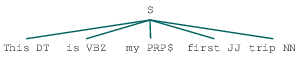

In [14]:
chunker.parse(nltk.pos_tag(nltk.word_tokenize('This is my first trip')))